# Epilepsy Data Processing Pipeline

## Libraries

In [1]:
# Epilepsy Data Processing Pipeline
import os
import re
import json
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from tqdm import tqdm
import pywt
import warnings
import uuid
import base64
warnings.filterwarnings('ignore')

# MNE Libraries
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne_connectivity import spectral_connectivity_epochs
from mne.time_frequency import psd_array_multitaper

# Scipy and Scikit-learn
from scipy import signal, stats
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Torch
import torch
import torch.nn as nn

## Load Meta Data

In [2]:
def load_metadata_from_json(data_dir='data'):
    """Load patient and seizure metadata from JSON files using Polars"""
    data_dir = Path(data_dir)
    all_seizures = []
    all_patients = []
    all_non_seizures = []
    
    json_files = sorted(list(data_dir.glob('**/*.json')))
    print(f"Found {len(json_files)} JSON files")
    
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract patient-level information
            patient_info = {
                'patient_id': data['patient_id'],
                'age': data['age'],
                'gender': data['gender'],
                'sampling_rate_hz': data['sampling_rate_hz'],
                'num_channels': len(data['channels']),
                'json_file_path': str(json_file),
                'eeg_channel': data['eeg_channel'],
                'seizure_type': data['seizure_type'],
                'localization': data['localization'],
                'lateralization': data['lateralization'],
            }
            
            if 'file_name' in data:
                patient_info['file_name'] = data['file_name']
                patient_info['registration_start_time'] = data.get('registration_start_time')
                patient_info['registration_end_time'] = data.get('registration_end_time')
            
            all_patients.append(patient_info)
            
            # Process each seizure
            for seizure in data['seizures']:
                seizure_record = {
                    'seizure_index': str(uuid.uuid4())[:8],
                    'patient_id': data['patient_id'],
                    'seizure_bool': True,
                    'sampling_rate_hz': data['sampling_rate_hz'],
                    'seizure_number': seizure['seizure_number']
                }
                
                for key, value in seizure.items():
                    seizure_record[key] = value
                
                if 'file_name' in patient_info and 'file_name' not in seizure:
                    seizure_record['file_name'] = patient_info['file_name']
                    if 'registration_start_time' in patient_info:
                        seizure_record['registration_start_time'] = patient_info['registration_start_time']
                        seizure_record['registration_end_time'] = patient_info['registration_end_time']
                
                all_seizures.append(seizure_record)
                
            # Check if non_seizures exists before processing
            if 'non-seizures' in data:
                for non_seizure in data['non-seizures']:
                    non_seizure_record = {
                        'patient_id': data['patient_id'],
                        'seizure_bool': False,
                        'file_name': non_seizure['file_name'],
                        'registration_start_time': non_seizure['registration_start_time'],
                        'registration_end_time': non_seizure['registration_end_time']
                    }
                    
                    all_non_seizures.append(non_seizure_record)
                
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
            continue
    
    # Convert to Polars DataFrames
    seizures_df = pl.DataFrame(all_seizures)
    patients_df = pl.DataFrame(all_patients)
    non_seizures_df = pl.DataFrame(all_non_seizures)
    
    return seizures_df, patients_df, non_seizures_df

In [3]:
# Load metadata
print("Loading metadata from JSON files...")

# change to other folder for full set
seizures_df, patients_df, non_seizures_df = load_metadata_from_json(
    'data'
    )
print(f"Loaded {len(patients_df)} patients and {len(seizures_df)} seizures")

Loading metadata from JSON files...
Found 38 JSON files
Loaded 38 patients and 245 seizures


In [4]:
def fix_time_columns(df, time_cols):
    for col in time_cols:
        if col in df.columns:
            # First replace "N/A" with null
            df = df.with_columns(
                pl.when(pl.col(col) == "N/A")
                .then(None)
                .otherwise(pl.col(col))
                .alias(col)
            )
            
            # Replace literal '.' with ':' for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.replace_all(".", ":", literal=True))
                .otherwise(None)
                .alias(col)
            )
            
            # Split time string and wrap hours > 24 for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.split(":").list.to_struct()
                      .struct.rename_fields(["hour", "minute", "second"]))
                .otherwise(None)
                .alias(col + "_split")
            )
            
            # Reconstruct time with wrapped hours for non-null values
            df = df.with_columns(
                pl.when(pl.col(col + "_split").is_not_null())
                .then(
                    pl.concat_str(
                        [
                            (pl.col(col + "_split").struct.field("hour").cast(pl.Int32) % 24).cast(pl.Utf8).str.zfill(2),
                            pl.col(col + "_split").struct.field("minute").cast(pl.Utf8).str.zfill(2),
                            pl.col(col + "_split").struct.field("second").cast(pl.Utf8).str.zfill(2)
                        ],
                        separator=":"
                    )
                )
                .otherwise(None)
                .alias(col)
            ).drop(col + "_split")
            
            # Convert to time dtype for non-null values
            df = df.with_columns(
                pl.when(pl.col(col).is_not_null())
                .then(pl.col(col).str.to_time("%H:%M:%S"))
                .otherwise(None)
                .alias(col)
            )
    
    return df

In [5]:
time_cols = [
    'registration_start_time',
    'registration_end_time',
    'seizure_start_time',
    'seizure_end_time'
]

In [6]:
seizures_df = fix_time_columns(seizures_df, time_cols)

In [7]:
seizures_df.dtypes

[String, String, Boolean, Int64, Int64, String, Time, Time, Time, Time]

In [8]:
def save_to_csv(df, output_path='comprehensive_df.csv'):
    if isinstance(df, pl.DataFrame):
        df_pd = df.to_pandas()
    else:
        df_pd = df
    
    df_pd.to_csv(output_path, index=False)
    print(f"Dataset saved to: {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

def save_to_parquet(df, output_path='comprehensive_eeg_features.parquet'):
    if isinstance(df, pl.DataFrame):
        df.write_parquet(output_path)
    else:
        df.to_parquet(output_path, index=False, engine='pyarrow')
    
    print(f"Dataset saved to: {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

## Processing Functions

### PSD Features

In [9]:
def extract_psd_features(raw, fmin=0.4, fmax=50, prefix="seizure"):
    features = {}
    
    try:
        # Get data
        data = raw.get_data()
        sfreq = raw.info['sfreq']
        
        # Calculate PSD using multitaper (more robust than welch for non-stationary signals)
        psds, freqs = psd_array_multitaper(
            data, sfreq, fmin=fmin, fmax=fmax, 
            adaptive=True, normalization='full', verbose=False
        )
        
        # Extended frequency bands
        bands = {
            'delta': (0.4, 4),
            'theta': (4, 7),
            'alpha': (7, 12),
            'low_beta': (12, 20),
            'high_beta': (20, 30),
            'gamma': (30, 50),
            'high_gamma': (50, 60)
        }
        
        band_powers = {}
        
        for band_name, (low_freq, high_freq) in bands.items():
            freq_mask = (freqs >= low_freq) & (freqs < high_freq)
            if freq_mask.any():
                band_power = np.mean(psds[:, freq_mask], axis=1)
                band_powers[band_name] = band_power
                
                # Store band power statistics
                features[f'{prefix}_psd_{band_name}_mean'] = float(np.mean(band_power) * 1e+8)
                features[f'{prefix}_psd_{band_name}_std'] = float(np.std(band_power) * 1e+8)
                features[f'{prefix}_psd_{band_name}_cv'] = float(np.std(band_power) / (np.mean(band_power) + 1e-10))  # Coefficient of variation
        
        # Calculate band power ratios (important for seizure detection)
        if 'theta' in band_powers and 'alpha' in band_powers:
            features[f'{prefix}_psd_theta_alpha_ratio'] = float(np.mean(band_powers['theta']) / (np.mean(band_powers['alpha']) + 1e-8))
        
        if 'delta' in band_powers and 'alpha' in band_powers:
            features[f'{prefix}_psd_delta_alpha_ratio'] = float(np.mean(band_powers['delta']) / (np.mean(band_powers['alpha']) + 1e-8))
        
        if 'low_beta' in band_powers and 'high_beta' in band_powers:
            features[f'{prefix}_psd_beta_ratio'] = float(np.mean(band_powers['high_beta']) / (np.mean(band_powers['low_beta']) + 1e-8))
        
        # Spectral edge frequencies (SEF50, SEF90, SEF95)
        mean_psd = np.mean(psds, axis=0)
        cumsum_psd = np.cumsum(mean_psd)
        cumsum_psd = cumsum_psd / cumsum_psd[-1]
        
        for percentile in [50, 75, 90, 95]:
            edge_idx = np.where(cumsum_psd >= percentile/100)[0]
            if len(edge_idx) > 0:
                features[f'{prefix}_psd_sef{percentile}'] = float(freqs[edge_idx[0]])
            else:
                features[f'{prefix}_psd_sef{percentile}'] = float(freqs[-1])
        
        # Spectral centroid and spread
        freq_weights = freqs * mean_psd
        spectral_centroid = np.sum(freq_weights) / (np.sum(mean_psd) + 1e-8)
        features[f'{prefix}_psd_spectral_centroid'] = float(spectral_centroid)
        
        # Spectral spread (standard deviation around centroid)
        spectral_spread = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * mean_psd) / (np.sum(mean_psd) + 1e-8))
        features[f'{prefix}_psd_spectral_spread'] = float(spectral_spread)
        
        # Spectral skewness and kurtosis
        if spectral_spread > 0:
            spectral_skewness = np.sum(((freqs - spectral_centroid) ** 3) * mean_psd) / ((spectral_spread ** 3) * np.sum(mean_psd) + 1e-8)
            spectral_kurtosis = np.sum(((freqs - spectral_centroid) ** 4) * mean_psd) / ((spectral_spread ** 4) * np.sum(mean_psd) + 1e-8)
            features[f'{prefix}_psd_spectral_skewness'] = float(spectral_skewness)
            features[f'{prefix}_psd_spectral_kurtosis'] = float(spectral_kurtosis)
        else:
            features[f'{prefix}_psd_spectral_skewness'] = 0.0
            features[f'{prefix}_psd_spectral_kurtosis'] = 0.0
        
    except Exception as e:
        print(f"Error in enhanced PSD calculation: {e}")
    
    return features

In [10]:
def extract_psd_features_by_region(raw, fmin=0.4, fmax=60, prefix="seizure"):
    # Define channel groups for standard monopolar montage
    monopolar_channel_groups = {
        'frontal': ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz'],
        'central': ['C3', 'C4', 'Cz'],
        'parietal': ['P3', 'P4', 'Pz'],
        'occipital': ['O1', 'O2'],
        'temporal': ['T3', 'T4', 'T5', 'T6'],
        'left': ['Fp1', 'F3', 'F7', 'C3', 'P3', 'O1', 'T3', 'T5'],
        'right': ['Fp2', 'F4', 'F8', 'C4', 'P4', 'O2', 'T4', 'T6']
    }
    
    # Define channel groups for bipolar montage
    bipolar_channel_groups = {
        'frontal': ['FP1-F7', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'F7-T7', 'F3-C3', 'F4-C4', 'F8-T8', 'FZ-CZ'],
        'temporal': ['F7-T7', 'F8-T8', 'T7-P7', 'T8-P8-0', 'T8-P8-1', 'P7-T7', 'T7-FT9', 'FT10-T8'],
        'frontotemporal': ['T7-FT9', 'FT9-FT10', 'FT10-T8'],
        'parietal': ['T7-P7', 'C3-P3', 'C4-P4', 'T8-P8-0', 'T8-P8-1', 'P7-O1', 'P3-O1', 'P4-O2', 'P8-O2', 'CZ-PZ', 'P7-T7'],
        'occipital': ['P7-O1', 'P3-O1', 'P4-O2', 'P8-O2'],
        'central': ['F3-C3', 'C3-P3', 'F4-C4', 'C4-P4', 'FZ-CZ', 'CZ-PZ'],
        'left': ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'P7-T7', 'T7-FT9'],
        'right': ['FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FT10-T8', 'T8-P8-1'],
        'midline': ['FZ-CZ', 'CZ-PZ'],
        'cross_hemisphere': ['FT9-FT10'],
        'left_lateral_chain': ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1'],
        'left_parasagittal_chain': ['FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1'],
        'right_parasagittal_chain': ['FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2'],
        'right_lateral_chain': ['FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2'],
        'midline_chain': ['FZ-CZ', 'CZ-PZ']
    }
    
    available_channels = raw.ch_names
    
    # Detect channel type based on presence of '-' in channel names
    def detect_channel_type(channels):
        bipolar_count = sum(1 for ch in channels if '-' in ch and not ch.startswith('EEG'))
        monopolar_count = sum(1 for ch in channels if '-' not in ch or ch.startswith('EEG'))
        
        # If majority of channels contain '-', it's likely bipolar montage
        if bipolar_count > monopolar_count * 0.5:
            return 'bipolar'
        else:
            return 'monopolar'
    
    # Determine which channel groups to use
    channel_type = detect_channel_type(available_channels)
    
    if channel_type == 'bipolar':
        channel_groups = bipolar_channel_groups
        
        # Function to find matching bipolar channels
        def find_matching_channels(available_channels, channel_list):
            region_channels = []
            for ch in available_channels:
                ch_clean = ch.upper().replace('EEG', '').replace(' ', '').strip()
                for target_ch in channel_list:
                    target_clean = target_ch.upper()
                    # Check for exact match after normalization
                    if ch_clean == target_clean:
                        region_channels.append(ch)
                        break
                    # Check for P8 variations (P8-O2 vs T8-P8-0/T8-P8-1)
                    elif 'P8' in target_clean and 'P8' in ch_clean:
                        # Handle the special case of P8 channels
                        if (target_clean in ch_clean) or (ch_clean in target_clean):
                            region_channels.append(ch)
                            break
            return region_channels
            
    else:
        channel_groups = monopolar_channel_groups
        
        # Function to find matching monopolar channels (your original logic)
        def find_matching_channels(available_channels, channel_list):
            region_channels = []
            for ch in available_channels:
                ch_clean = ch.upper().replace('EEG', '').replace('-', '').replace(' ', '').strip()
                for target_ch in channel_list:
                    if target_ch.upper() in ch_clean or ch_clean in target_ch.upper():
                        region_channels.append(ch)
                        break
            return region_channels
    
    # Process each region
    regional_features = {}
    
    for region, channel_list in channel_groups.items():
        # Find matching channels for this region
        region_channels = find_matching_channels(available_channels, channel_list)
        
        if region_channels:
            try:
                # Pick channels for this region
                raw_region = raw.copy().pick(region_channels)
                
                # Extract features for this region
                region_psd_features = extract_psd_features(raw_region, fmin, fmax, prefix)
                
                # Add region prefix to feature names
                for feature_name, value in region_psd_features.items():
                    regional_features[f'{region}_{feature_name}'] = value
                    
                #print(f"Processed {region} region with {len(region_channels)} channels")
                    
            except Exception as e:
                print(f"Could not process {region} region: {e}")
        else:
            print(f"No channels found for {region} region")
    
    return regional_features

In [11]:
def parse_seizure_time(time_str):
    if pd.isna(time_str) or time_str == '' or time_str is None:
        return None
    
    try:
        time_str = str(time_str).strip()
        
        # Handle HH:MM:SS or MM:SS format
        if '.' in time_str:
            parts = time_str.split('.')
            if len(parts) == 3:
                hours, minutes, seconds = map(float, parts)
                return hours * 3600 + minutes * 60 + seconds
            elif len(parts) == 2:
                minutes, seconds = map(float, parts)
                return minutes * 60 + seconds
        
        # Handle pure seconds
        return float(time_str)
        
    except Exception as e:
        print(f"Could not parse time '{time_str}': {e}")
        return None

### Differential Entropy

In [12]:
def calculate_differential_entropy(data, sfreq, bands=None, prefix="seizure"):
    if bands is None:
        bands = {
            'delta': (0.4, 4),
            'theta': (4, 7),
            'alpha': (7, 12),
            'low_beta': (12, 20),
            'high_beta': (20, 30),
            'gamma': (30, 50),
            'high_gamma': (50, 60)
        }
    
    features = {}
    n_channels = data.shape[0]
    
    for band_name, (low_freq, high_freq) in bands.items():
        # Bandpass filter for each band
        try:
            filtered_data = mne.filter.filter_data(
                data, sfreq, l_freq=low_freq, h_freq=high_freq, 
                verbose=False, method='fir', fir_design='firwin'
            )
            
            # Calculate variance for each channel
            variances = np.var(filtered_data, axis=1)
            
            # Calculate DE: 0.5 * log(2 * pi * e * variance)
            # Adding small epsilon to avoid log(0)
            de_values = 0.5 * np.log(2 * np.pi * np.e * (variances + 1e-8))
            
            # Store statistics
            features[f'{prefix}_de_{band_name}_mean'] = float(np.mean(de_values))
            features[f'{prefix}_de_{band_name}_std'] = float(np.std(de_values))
            features[f'{prefix}_de_{band_name}_median'] = float(np.median(de_values))
            features[f'{prefix}_de_{band_name}_max'] = float(np.max(de_values))
            features[f'{prefix}_de_{band_name}_min'] = float(np.min(de_values))
            
            # Asymmetry features (frontal asymmetry is important for emotion/seizure)
            if n_channels >= 2:
                # Calculate hemispheric asymmetry
                left_channels = de_values[:n_channels//2]
                right_channels = de_values[n_channels//2:]
                min_len = min(len(left_channels), len(right_channels))
                if min_len > 0:
                    asymmetry = left_channels[:min_len] - right_channels[:min_len]
                    features[f'{prefix}_de_{band_name}_asymmetry_mean'] = float(np.mean(asymmetry))
                    features[f'{prefix}_de_{band_name}_asymmetry_std'] = float(np.std(asymmetry))
                
        except Exception as e:
            print(f"Error calculating DE for {band_name}: {e}")
    
    return features

### Propagation

In [13]:
# simple propagation
def calculate_simple_propagation_features(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels, n_samples = data.shape
        
        # Calculate onset time for each channel
        onset_times = []
        
        for ch_idx in range(n_channels):
            channel_data = data[ch_idx, :]
            
            # Calculate envelope
            analytic_signal = signal.hilbert(channel_data)
            envelope = np.abs(analytic_signal)
            
            # Simple smoothing
            window_samples = max(3, int(0.1 * sfreq))
            if window_samples % 2 == 0:
                window_samples += 1
            envelope_smooth = signal.savgol_filter(
                envelope, 
                window_samples, 
                min(1, window_samples-1)
            )
            
            # Find onset as first time envelope exceeds threshold
            baseline = np.median(envelope_smooth[:int(0.5 * sfreq)])  # Use first 0.5s as baseline
            threshold = baseline + 2 * np.std(envelope_smooth[:int(0.5 * sfreq)])
            
            # Find first crossing of threshold
            above_threshold = envelope_smooth > threshold
            if np.any(above_threshold):
                onset_idx = np.argmax(above_threshold)
                onset_times.append(onset_idx / sfreq)
        
        print(f'Detected {len(onset_times)} onset times')
        
        if len(onset_times) > 0:
            onset_times = np.array(onset_times)
            
            # Calculate propagation metrics
            sorted_onsets = np.sort(onset_times)
            delays = np.diff(sorted_onsets)
            
            # Propagation speed estimates
            avg_distance_mm = 10  # Distance between electrodes in mm
            speeds = []
            
            positive_delays = delays[delays > 0]
            if len(positive_delays) > 0:
                speeds = avg_distance_mm / positive_delays
                
                features[f'{prefix}_mean_propagation_speed'] = float(np.mean(speeds))
                features[f'{prefix}_median_propagation_speed'] = float(np.median(speeds))
                features[f'{prefix}_std_propagation_speed'] = float(np.std(speeds))
                features[f'{prefix}_max_propagation_speed'] = float(np.max(speeds))
                features[f'{prefix}_min_propagation_speed'] = float(np.min(speeds))
                features[f'{prefix}_num_propagation_events'] = len(speeds)
            
            # Onset timing features
            features[f'{prefix}_earliest_onset'] = float(np.min(onset_times))
            features[f'{prefix}_latest_onset'] = float(np.max(onset_times))
            features[f'{prefix}_onset_spread'] = float(np.max(onset_times) - np.min(onset_times))
            
            if len(delays) > 0:
                features[f'{prefix}_mean_onset_delay'] = float(np.mean(delays))
                features[f'{prefix}_max_onset_delay'] = float(np.max(delays))
                
    except Exception as e:
        print(f"Error in propagation calculation: {e}")
    
    return features

In [14]:
# peak based propagation
def calculate_propagation_features_peak_based(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels, n_samples = data.shape
        
        onset_times = []
        peak_times = []
        
        for ch_idx in range(n_channels):
            channel_data = data[ch_idx, :]
            
            # Calculate envelope
            analytic_signal = signal.hilbert(channel_data)
            envelope = np.abs(analytic_signal)
            
            # Smooth envelope
            window_samples = max(3, int(0.05 * sfreq))
            if window_samples % 2 == 0:
                window_samples += 1
            envelope_smooth = signal.savgol_filter(
                envelope, 
                window_samples, 
                min(1, window_samples-1)
            )
            
            # Find the time of maximum activity (peak)
            peak_idx = np.argmax(envelope_smooth)
            peak_times.append(peak_idx / sfreq)
            
            # Find onset using derivative
            envelope_diff = np.diff(envelope_smooth)
            threshold = np.std(envelope_diff[:int(0.5 * sfreq)]) * 2
            
            significant_rise = envelope_diff > threshold
            if np.any(significant_rise):
                onset_idx = np.argmax(significant_rise)
                onset_times.append(onset_idx / sfreq)
        
        print(f'Found {len(onset_times)} onsets and {len(peak_times)} peaks')
        
        # Calculate features from onset times
        if len(onset_times) > 0:
            onset_array = np.array(onset_times)
            sorted_onsets = np.sort(onset_array)
            delays = np.diff(sorted_onsets)
            
            # Speed calculations
            avg_distance_mm = 10
            positive_delays = delays[delays > 0]
            
            if len(positive_delays) > 0:
                speeds = avg_distance_mm / positive_delays
                
                features[f'{prefix}_mean_propagation_speed'] = float(np.mean(speeds))
                features[f'{prefix}_median_propagation_speed'] = float(np.median(speeds))
                features[f'{prefix}_std_propagation_speed'] = float(np.std(speeds))
                features[f'{prefix}_max_propagation_speed'] = float(np.max(speeds))
                features[f'{prefix}_min_propagation_speed'] = float(np.min(speeds))
            
            features[f'{prefix}_onset_spread'] = float(np.max(onset_array) - np.min(onset_array))
            features[f'{prefix}_mean_onset_time'] = float(np.mean(onset_array))
            
        # Calculate features from peak times
        if len(peak_times) > 0:
            peak_array = np.array(peak_times)
            features[f'{prefix}_peak_spread'] = float(np.max(peak_array) - np.min(peak_array))
            features[f'{prefix}_mean_peak_time'] = float(np.mean(peak_array))
            
    except Exception as e:
        print(f"Error: {e}")
    
    return features

### Wavelet

In [15]:
def calculate_wavelet_features(data, sfreq, wavelet='db4', levels=5, prefix="seizure"):
    features = {}
    n_channels = data.shape[0]
    
    # Store features for each decomposition level
    all_channel_features = []
    
    for ch_idx in range(n_channels):
        channel_data = data[ch_idx, :]
        
        try:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel_data, wavelet, level=levels)
            
            # Calculate features for each level
            channel_features = []
            for level, coeff in enumerate(coeffs):
                if len(coeff) > 0:
                    # Energy of coefficients
                    energy = np.sum(coeff ** 2)
                    # Entropy
                    entropy = stats.entropy(np.abs(coeff) + 1e-8)
                    # Statistical features
                    mean_coeff = np.mean(np.abs(coeff))
                    std_coeff = np.std(coeff)
                    max_coeff = np.max(np.abs(coeff))
                    
                    channel_features.extend([energy, entropy, mean_coeff, std_coeff, max_coeff])
                else:
                    channel_features.extend([0.0, 0.0, 0.0, 0.0, 0.0])
            
            all_channel_features.append(channel_features)
            
        except Exception as e:
            print(f"Error in wavelet transform for channel {ch_idx}: {e}")
            # Add zeros for failed channel
            all_channel_features.append([0.0] * (5 * (levels + 1)))
    
    # Aggregate across channels
    all_channel_features = np.array(all_channel_features)
    
    # Store aggregated features
    feature_names = ['energy', 'entropy', 'mean', 'std', 'max']
    for level in range(levels + 1):
        for feat_idx, feat_name in enumerate(feature_names):
            feat_values = all_channel_features[:, level * 5 + feat_idx]
            features[f'{prefix}_wt_level{level}_{feat_name}_mean'] = round(float(np.mean(feat_values)), 12)
            features[f'{prefix}_wt_level{level}_{feat_name}_std'] = round(float(np.std(feat_values)), 12)
    
    # Calculate wavelet packet energy distribution
    try:
        # Use first channel for packet decomposition (computationally expensive for all)
        wp = pywt.WaveletPacket(data[0, :], wavelet, maxlevel=3)
        packet_energies = []
        for node in wp.get_level(3):
            packet_energies.append(np.sum(node.data ** 2))
        
        if packet_energies:
            total_energy = sum(packet_energies)
            if total_energy > 0:
                normalized_energies = np.array([e/total_energy for e in packet_energies])
                features[f'{prefix}_wt_packet_entropy'] = float(stats.entropy(normalized_energies + 1e-8))
            else:
                features[f'{prefix}_wt_packet_entropy'] = 0.0
        else:
            features[f'{prefix}_wt_packet_entropy'] = 0.0
            
    except Exception as e:
        print(f"Error in wavelet packet decomposition: {e}")
    
    return features

### Time Domain

In [16]:
def calculate_time_domain_features(data, sfreq, prefix="seizure"):
    features = {}
    n_channels, n_samples = data.shape
    
    try:
        # Statistical features for each channel
        channel_features = {
            'mean': np.mean(data, axis=1),
            'std': np.std(data, axis=1),
            'var': np.var(data, axis=1),
            'skewness': stats.skew(data, axis=1),
            'kurtosis': stats.kurtosis(data, axis=1),
            'rms': np.sqrt(np.mean(data ** 2, axis=1)),
            'peak_to_peak': np.ptp(data, axis=1),
            'zero_crossings': np.sum(np.diff(np.sign(data), axis=1) != 0, axis=1) / (n_samples / sfreq),  # Rate per second
        }
        
        # Hjorth parameters
        # Activity (variance of signal)
        activity = (np.var(data, axis=1) * 1e+8)
        
        # Mobility (standard deviation of first derivative / standard deviation of signal)
        first_deriv = np.diff(data, axis=1)
        mobility = np.std(first_deriv, axis=1) / (np.std(data, axis=1) + 1e-8)
        
        # Complexity (mobility of first derivative / mobility of signal)
        second_deriv = np.diff(first_deriv, axis=1)
        mobility_deriv = np.std(second_deriv, axis=1) / (np.std(first_deriv, axis=1) + 1e-8)
        complexity = mobility_deriv / (mobility + 1e-8)
        
        channel_features['hjorth_activity'] = activity
        channel_features['hjorth_mobility'] = mobility
        channel_features['hjorth_complexity'] = complexity
        
        # Line length (sum of absolute differences)
        line_length = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / n_samples
        channel_features['line_length'] = line_length
        
        # Non-linear energy
        nonlinear_energy = []
        for ch in range(n_channels):
            if n_samples >= 3:
                nle = np.mean(data[ch, 1:-1]**2 - data[ch, :-2] * data[ch, 2:])
                nonlinear_energy.append(nle)
            else:
                nonlinear_energy.append(0.0)
        channel_features['nonlinear_energy'] = np.array(nonlinear_energy)
        
        # Aggregate features across channels
        for feat_name, feat_values in channel_features.items():
            features[f'{prefix}_time_{feat_name}_mean'] = round(float(np.mean(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_std'] = round(float(np.std(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_max'] = round(float(np.max(feat_values)), 12)
            features[f'{prefix}_time_{feat_name}_min'] = round(float(np.min(feat_values)), 12)
        
    except Exception as e:
        print(f"Error in time-domain feature calculation: {e}")
    
    return features

### Connectivity

In [17]:
def calculate_connectivity_features(raw, fmin=0.4, fmax=50, prefix="seizure"):
    features = {}
    
    try:
        data = raw.get_data()
        n_channels, n_samples = data.shape
        sfreq = raw.info['sfreq']
        
        # Only calculate if we have multiple channels
        if n_channels < 2:
            raise ValueError("Need at least 2 channels for connectivity")
        
        # Reshape data for connectivity calculation (n_epochs, n_channels, n_times)
        # Create pseudo-epochs by segmenting the data
        epoch_length = int(2 * sfreq)  # 2-second epochs
        n_epochs = n_samples // epoch_length
        
        if n_epochs > 0:
            epochs_data = []
            for i in range(n_epochs):
                start = i * epoch_length
                end = start + epoch_length
                epochs_data.append(data[:, start:end])
            epochs_data = np.array(epochs_data)
            
            # Calculate spectral connectivity
            # Using coherence as the connectivity measure
            con = spectral_connectivity_epochs(
                epochs_data, method='coh', mode='multitaper',
                sfreq=sfreq, fmin=fmin, fmax=fmax,
                verbose=False
            )
            
            # Get connectivity matrix (n_channels x n_channels x n_freqs)
            con_matrix = con.get_data(output='dense')
            
            # Average across frequencies
            mean_connectivity = np.mean(con_matrix, axis=2)
            
            # Extract upper triangle (excluding diagonal)
            upper_tri = np.triu_indices_from(mean_connectivity, k=1)
            connectivity_values = mean_connectivity[upper_tri]
            
            # Store connectivity statistics - these aren't working
            #features[f'{prefix}_connectivity_mean'] = np.mean(connectivity_values)
            #features[f'{prefix}_connectivity_std'] = np.std(connectivity_values)
            #features[f'{prefix}_connectivity_max'] = np.max(connectivity_values)
            #features[f'{prefix}_connectivity_min'] = np.min(connectivity_values)
            
            # Global efficiency (mean of connectivity)
            #features[f'{prefix}_global_efficiency'] = np.mean(connectivity_values)
            
            # Node strength (sum of connections for each node)
            node_strengths = np.sum(mean_connectivity, axis=0) - 1  # Subtract diagonal
            features[f'{prefix}_node_strength_mean'] = float(np.mean(node_strengths))
            features[f'{prefix}_node_strength_std'] = float(np.std(node_strengths))
            features[f'{prefix}_node_strength_max'] = float(np.max(node_strengths))
            
            # Clustering coefficient (simplified version) - doesn't work
            #clustering_coeffs = []
            #for i in range(n_channels):
            #    neighbors = mean_connectivity[i, :] > 0.01  # Threshold for connection
            #    n_neighbors = np.sum(neighbors) - 1  # Exclude self
            #    if n_neighbors > 1:
            #        # Count connections between neighbors
            #        neighbor_indices = np.where(neighbors)[0]
            #        neighbor_connections = 0
            #        for j in range(len(neighbor_indices)):
            #            for k in range(j+1, len(neighbor_indices)):
            #                if mean_connectivity[neighbor_indices[j], neighbor_indices[k]] > 0.3:
            #                    neighbor_connections += 1
            #        max_connections = n_neighbors * (n_neighbors - 1) / 2
            #        if max_connections > 0:
            #            clustering = neighbor_connections / max_connections
            #            clustering_coeffs.append(clustering)
            
            #features[f'{prefix}_clustering_coefficient'] = float(np.mean(clustering_coeffs))
  
        else:
            raise ValueError("Not enough data for connectivity analysis")
            
    except Exception as e:
        print(f"Error in connectivity calculation: {e}")
    
    return features

### PAC

In [18]:
def calculate_pac_features(data, sfreq, prefix="seizure"):
    features = {}
    
    try:
        n_channels = data.shape[0]
        
        # Define phase and amplitude frequency bands
        phase_bands = {
            'theta': (4, 7),
            'alpha': (7, 12)
        }
        
        amplitude_bands = {
            'gamma': (30, 50),
            'high_gamma': (50, 100)
        }
        
        pac_values = []
        
        for phase_name, (phase_low, phase_high) in phase_bands.items():
            for amp_name, (amp_low, amp_high) in amplitude_bands.items():
                
                channel_pac = []
                for ch in range(min(n_channels, 10)):  # Limit to first 10 channels for speed
                    # Extract phase
                    phase_filtered = mne.filter.filter_data(
                        data[ch:ch+1, :], sfreq, 
                        l_freq=phase_low, h_freq=phase_high,
                        verbose=False
                    )
                    phase = np.angle(signal.hilbert(phase_filtered[0]))
                    
                    # Extract amplitude
                    amp_filtered = mne.filter.filter_data(
                        data[ch:ch+1, :], sfreq,
                        l_freq=amp_low, h_freq=amp_high,
                        verbose=False
                    )
                    amplitude = np.abs(signal.hilbert(amp_filtered[0]))
                    
                    # Calculate PAC using Modulation Index
                    n_bins = 18
                    phase_bins = np.linspace(-np.pi, np.pi, n_bins + 1)
                    amp_by_phase = []
                    
                    for i in range(n_bins):
                        mask = (phase >= phase_bins[i]) & (phase < phase_bins[i+1])
                        if np.sum(mask) > 0:
                            amp_by_phase.append(np.mean(amplitude[mask]))
                        else:
                            amp_by_phase.append(0)
                    
                    # Normalize and calculate entropy
                    amp_by_phase = np.array(amp_by_phase)
                    if np.sum(amp_by_phase) > 0:
                        amp_by_phase = amp_by_phase / np.sum(amp_by_phase)
                        # Kullback-Leibler divergence from uniform distribution
                        uniform = np.ones(n_bins) / n_bins
                        kl_div = np.sum(amp_by_phase * np.log((amp_by_phase + 1e-10) / uniform))
                        mi = kl_div / np.log(n_bins)  # Normalized MI
                        channel_pac.append(mi)
                    else:
                        channel_pac.append(0.0)
                
                if channel_pac:
                    pac_value = np.mean(channel_pac)
                    features[f'{prefix}_pac_{phase_name}_{amp_name}'] = float(pac_value)
                    pac_values.append(pac_value)
                else:
                    features[f'{prefix}_pac_{phase_name}_{amp_name}'] = 0.0
        
        # Overall PAC statistics
        features[f'{prefix}_pac_mean'] = float(np.mean(pac_values))
        features[f'{prefix}_pac_max'] = float(np.max(pac_values))
            
    except Exception as e:
        print(f"Error in PAC calculation: {e}")
    
    return features

### Sample, Permutation, and Approximate Entropy

In [19]:
def calculate_entropy_features(data, sfreq, prefix="seizures"):
    features = {}
    
    try:
        n_channels = data.shape[0]
        
        # Sample Entropy
        sample_entropies = []
        for ch in range(min(n_channels, 10)): 
            # Downsample for faster computation
            downsampled = signal.resample(data[ch, :], min(1000, len(data[ch, :])))
            # Simple sample entropy approximation
            se = calculate_sample_entropy(downsampled, m=2, r=0.2*np.std(downsampled))
            sample_entropies.append(se)
        
        features[f'{prefix}_sample_entropy_mean'] = float(np.mean(sample_entropies))
        features[f'{prefix}_sample_entropy_std'] = float(np.std(sample_entropies))
        
        # Permutation Entropy
        perm_entropies = []
        for ch in range(min(n_channels, 10)):
            pe = calculate_permutation_entropy(data[ch, :], order=3, delay=1)
            perm_entropies.append(pe)
        
        features[f'{prefix}_permutation_entropy_mean'] = float(np.mean(perm_entropies))
        features[f'{prefix}_permutation_entropy_std'] = float(np.std(perm_entropies))
        
        # Approximate Entropy (simplified)
        approx_entropies = []
        for ch in range(min(n_channels, 10)):
            downsampled = signal.resample(data[ch, :], min(1000, len(data[ch, :])))
            ae = calculate_approx_entropy(downsampled, m=2, r=0.2*np.std(downsampled))
            approx_entropies.append(ae)
        
        features[f'{prefix}_approx_entropy_mean'] = float(np.mean(approx_entropies))
        features[f'{prefix}_approx_entropy_std'] = float(np.std(approx_entropies))
        
    except Exception as e:
        print(f"Error in entropy calculation: {e}")
    
    return features

def calculate_sample_entropy(signal_data, m=2, r=0.2):
    """Calculate sample entropy"""
    N = len(signal_data)
    
    def _maxdist(x_i, x_j, m):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    def _phi(m):
        patterns = np.array([signal_data[i:i+m] for i in range(N - m + 1)])
        C = 0
        for i in range(len(patterns)):
            for j in range(i+1, len(patterns)):
                if _maxdist(patterns[i], patterns[j], m) <= r:
                    C += 1
        return C
    
    try:
        phi_m = _phi(m)
        phi_m1 = _phi(m + 1)
        
        if phi_m == 0:
            return 0
        return -np.log(phi_m1 / phi_m) if phi_m1 > 0 else 0
    except:
        return 0

def calculate_permutation_entropy(signal_data, order=3, delay=1):
    """Calculate permutation entropy"""
    try:
        n = len(signal_data)
        permutations = []
        
        for i in range(n - delay * (order - 1)):
            indices = [i + j * delay for j in range(order)]
            sorted_indices = np.argsort(signal_data[indices])
            permutations.append(tuple(sorted_indices))
        
        # Count occurrences
        unique, counts = np.unique(permutations, axis=0, return_counts=True)
        probs = counts / len(permutations)
        
        # Calculate entropy
        return -np.sum(probs * np.log(probs + 1e-8))
    except:
        return 0

def calculate_approx_entropy(signal_data, m=2, r=0.2):
    """Calculate approximate entropy"""
    try:
        N = len(signal_data)
        
        def _maxdist(x_i, x_j, m):
            return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        
        def _phi(m):
            patterns = np.array([signal_data[i:i+m] for i in range(N - m + 1)])
            C = np.zeros(N - m + 1)
            
            for i in range(N - m + 1):
                matches = 0
                for j in range(N - m + 1):
                    if _maxdist(patterns[i], patterns[j], m) <= r:
                        matches += 1
                C[i] = matches / (N - m + 1)
            
            return np.mean(np.log(C + 1e-8))
        
        return _phi(m) - _phi(m + 1)
    except:
        return 0

### Rhythmic Features

In [20]:
def calculate_rhythmic_features(data, sfreq, prefix="seizure"):
    features = {}
    
    def bandpass_filter(channel_data, lowcut, highcut, fs):
        nyquist = fs / 2
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(4, [low, high], btype='band')
        return filtfilt(b, a, channel_data)
    
    n_channels = data.shape[0]
    
    # Initialize arrays for each feature
    theta_powers = []
    delta_slow_powers = []
    fast_powers = []
    spike_rates = []
    
    for channel_idx in range(n_channels):
        channel = data[channel_idx, :]
        
        # Theta rhythm (5-7 Hz)
        theta_filtered = bandpass_filter(channel, 5, 7, sfreq)
        theta_power = np.mean(theta_filtered**2)
        theta_powers.append(theta_power)
        
        # Delta slow rhythm (2-5 Hz)
        delta_slow_filtered = bandpass_filter(channel, 2, 5, sfreq)
        delta_slow_power = np.mean(delta_slow_filtered**2)
        delta_slow_powers.append(delta_slow_power)
        
        # Fast activity (15-25 Hz)
        fast_filtered = bandpass_filter(channel, 15, 25, sfreq)
        fast_power = np.mean(fast_filtered**2)
        fast_powers.append(fast_power)
        
        # Spike detection
        threshold = 3 * np.std(channel)
        spikes = np.where(np.abs(channel) > threshold)[0]
        spike_rate = len(spikes) / (len(channel) / sfreq)
        spike_rates.append(spike_rate)
    
    # Store features
    features[f'{prefix}_rhythmic_theta_power_mean'] = float(np.mean(theta_powers) * 1e+8)
    features[f'{prefix}_rhythmic_theta_power_std'] = float(np.std(theta_powers) * 1e+8)
    features[f'{prefix}_rhythmic_delta_slow_power_mean'] = float(np.mean(delta_slow_powers) * 1e+8)
    features[f'{prefix}_rhythmic_delta_slow_power_std'] = float(np.std(delta_slow_powers) * 1e+8)
    features[f'{prefix}_rhythmic_fast_power_mean'] = float(np.mean(fast_powers) * 1e+8)
    features[f'{prefix}_rhythmic_fast_power_std'] = float(np.std(fast_powers) * 1e+8)
    features[f'{prefix}_rhythmic_spike_rate_mean'] = float(np.mean(spike_rates))
    features[f'{prefix}_rhythmic_spike_rate_std'] = float(np.std(spike_rates))
    
    # Ratios
    features[f'{prefix}_rhythmic_theta_delta_ratio'] = float(np.mean(theta_powers) / (np.mean(delta_slow_powers) + 1e-8))
    features[f'{prefix}_rhythmic_fast_theta_ratio'] = float(np.mean(fast_powers) / (np.mean(theta_powers) + 1e-8))
    
    return features

## Process Single EDF File Function

In [ ]:
def process_single_edf(
                    edf_path, 
                    seizure_info, 
                    registration_start,
                    registration_end,
                    seizure_start,
                    seizure_end,
                    seizure_start_seconds,
                    seizure_end_seconds,
                    onset_sec,
                    postictal_onset_sec,
                    registration_end_seconds,
                    postictal_end_sec):
    
    features = {}
    
    try:
        # Load EDF file
        raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)
        
        # Basic file info
        features['file_path'] = str(edf_path)
        features['num_channels'] = len(raw.ch_names)
        features['sampling_rate'] = raw.info['sfreq']
        features['duration_seconds'] = raw.n_times / raw.info['sfreq']

        # Add seizure timing info
        features['seizure_start_seconds'] = seizure_start_seconds
        features['seizure_end_seconds'] = seizure_end_seconds
        
        # channels available
        available_channels = raw.ch_names
        
        # Apply bandpass filter
        raw.filter(0.4, 50, fir_design='firwin', verbose=False)

        # Get data
        sfreq = raw.info['sfreq']
        
        # Create raw seizure section
        seizure_raw = raw.copy().crop(tmin=onset_sec, tmax=postictal_onset_sec)
        seizure_data = seizure_raw.get_data()

        # Feature extraction functions
        de_features = calculate_differential_entropy(seizure_data, sfreq)
        features.update(de_features)

        entropy_features = calculate_entropy_features(seizure_data, sfreq)
        features.update(entropy_features)
        
        psd_features = extract_psd_features(seizure_raw)
        features.update(psd_features)
        
        psd_regional_features = extract_psd_features_by_region(seizure_raw)
        features.update(psd_regional_features)
        
        wt_features = calculate_wavelet_features(seizure_data, sfreq)
        features.update(wt_features)
        
        time_features = calculate_time_domain_features(seizure_data, sfreq)
        features.update(time_features)
        
        connectivity_features = calculate_connectivity_features(seizure_raw)
        features.update(connectivity_features)
        
        pac_features = calculate_pac_features(seizure_data, sfreq)
        features.update(pac_features)
    
        rhythmic_features = calculate_rhythmic_features(seizure_data, sfreq)
        features.update(rhythmic_features)

        # Propagation features
        propagation_features = calculate_simple_propagation_features(seizure_data, sfreq)
        features.update(propagation_features)
        
        peak_propagation_features = calculate_propagation_features_peak_based(seizure_data, sfreq) 
        features.update(peak_propagation_features)

        # Create raw post-ictal section
        post_ictal_raw = raw.copy().crop(tmin=postictal_onset_sec, tmax=postictal_end_sec)
        post_ictal_data = post_ictal_raw.get_data()

        post_ictal_psd_features = extract_psd_features(post_ictal_raw, prefix="post_ictal")
        features.update(post_ictal_psd_features)
        
        post_ictal_psd_regional_features = extract_psd_features_by_region(post_ictal_raw, prefix="post_ictal")
        features.update(post_ictal_psd_regional_features)
        
        post_ictal_wt_features = calculate_wavelet_features(post_ictal_data, sfreq, prefix="post_ictal")
        features.update(post_ictal_wt_features)
        
        features['processing_success'] = True
        features['error_message'] = ''
        
    except Exception as e:
        print(f"Error processing {edf_path}: {e}")
        features['processing_success'] = False
        features['error_message'] = str(e)
    
    return features

## Build Comprehensive Dataset

In [ ]:
def build_comprehensive_dataset(seizures_df, patients_df, non_seizures_df, 
                              data_root_paths=['data/siena_scalp', 'data/chb-mit']):
    all_records = []
    
    # Convert Polars to pandas for iteration (if needed)
    if isinstance(seizures_df, pl.DataFrame):
        seizures_pd = seizures_df.to_pandas()
        patients_pd = patients_df.to_pandas()
        non_seizures_pd = non_seizures_df.to_pandas()
    else:
        seizures_pd = seizures_df
        patients_pd = patients_df
        non_seizures_pd = non_seizures_df
    
    print(f"Processing {len(seizures_pd)} seizure records...")
    print("="*60)
    
    # options for testing
    # for idx, seizure_row in tqdm(seizures_pd.iloc[:5].iterrows(), total=5):
    # for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)): 
    
    for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)): 
        record = {}
        
        # Add all seizure metadata
        for col in seizure_row.index:
            record[f'{col}'] = seizure_row[col]
        
        # Find corresponding patient and seizure info
        patient_id = seizure_row['patient_id']
        patient_info = patients_pd[patients_pd['patient_id'] == patient_id]
        registration_start = seizure_row['registration_start_time']
        registration_end = seizure_row['registration_end_time']
        seizure_start = seizure_row['seizure_start_time']
        seizure_end = seizure_row['seizure_end_time']

        # Calculate registration and seizure total seconds
        registration_start_seconds = registration_start.hour * 3600 + registration_start.minute * 60 + registration_start.second
        registration_end_seconds = registration_end.hour * 3600 + registration_end.minute * 60 + registration_end.second
        seizure_start_seconds = seizure_start.hour * 3600 + seizure_start.minute * 60 + seizure_start.second
        seizure_end_seconds = seizure_end.hour * 3600 + seizure_end.minute * 60 + seizure_end.second
        seizure_duration = (seizure_end_seconds - seizure_start_seconds)

        if seizure_start_seconds < registration_start_seconds:
            reg_adjusted = (86400 - registration_start_seconds)
            onset_sec = (seizure_start_seconds + reg_adjusted)
            postictal_onset_sec = (seizure_end_seconds + reg_adjusted)
        else:
            onset_sec = (seizure_start_seconds - registration_start_seconds)
            postictal_onset_sec = (seizure_end_seconds - registration_start_seconds)
        
        if registration_start_seconds > registration_end_seconds:
            edf_file_duration = ((registration_end_seconds + 86400) - registration_start_seconds)
        else:
            edf_file_duration = (registration_end_seconds - registration_start_seconds)
            
        postictal_end_sec = (edf_file_duration - 1)

        # Find EDF file
        file_name = seizure_row['file_name']
        edf_path = None
        
        print(f'Patient id: {patient_id}')
        print(f'Edf file: {file_name}')
        print(f'Registration start: {registration_start}')
        print(f'Registration end: {registration_end}')
        print(f'Registration start seconds: {registration_start_seconds}')
        print(f'Registration end seconds: {registration_end_seconds}')
        print(f'EDF file duration: {edf_file_duration}')
        print(f'Seizure start: {seizure_start}')
        print(f'Seizure end: {seizure_end}')
        print(f'Seizure start seconds: {seizure_start_seconds}')
        print(f'Seizure end seconds: {seizure_end_seconds}')
        print(f'Seizure duration: {seizure_duration}')
        print(f'Seizure onset seconds: {onset_sec}')
        print(f'Post-ictal onset seconds: {postictal_onset_sec}')
        print(f'Post-ictal end seconds: {postictal_end_sec}')
        
        if not patient_info.empty:
            for col in patient_info.columns:
                if col != 'patient_id':  # Avoid duplication
                    record[f'{col}'] = patient_info.iloc[0][col]
        
        for root_path in data_root_paths:
            possible_paths = [
                os.path.join(root_path, patient_id, file_name),
                os.path.join(root_path, patient_id.lower(), file_name),
                os.path.join(root_path, patient_id.upper(), file_name),
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    edf_path = path
                    break
            
            if edf_path:
                break
        
        if edf_path:
            # Process EDF and extract features - pass the entire row as dict
            edf_features = process_single_edf(
                                    edf_path, 
                                    seizure_row.to_dict(),
                                    registration_start,
                                    registration_end,
                                    seizure_start,
                                    seizure_end,
                                    seizure_start_seconds,
                                    seizure_end_seconds,
                                    onset_sec,
                                    postictal_onset_sec,
                                    registration_end_seconds,
                                    postictal_end_sec
                                    )
            record.update(edf_features)
        else:
            record['processing_success'] = False
            record['error_message'] = 'EDF file not found'
        
        all_records.append(record)
    
    # Create comprehensive dataframe using Polars
    comprehensive_df = pl.DataFrame(all_records)
    
    # Print summary
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total records: {len(comprehensive_df)}")
    
    if 'processing_success' in comprehensive_df.columns:
        success_count = comprehensive_df.filter(pl.col('processing_success')).height
        print(f"Successfully processed: {success_count}")
        print(f"Failed: {len(comprehensive_df) - success_count}")
    
    return comprehensive_df

## Fill in Missing Values

In [23]:
def fill_missing_values_polars(df):
    # Get column types
    str_cols = [col for col in df.columns if df[col].dtype == pl.Utf8]
    num_cols = [col for col in df.columns if df[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64]]
    
    # Fill string columns with "N/A"
    for col in str_cols:
        df = df.with_columns(pl.col(col).fill_null("N/A"))
    
    # Fill numeric columns with 0
    for col in num_cols:
        df = df.with_columns(
            pl.col(col).fill_null(0).fill_nan(0)
        )
    
    return df

## Main Usage Function

In [ ]:
# Build comprehensive dataset
comprehensive_df = build_comprehensive_dataset(
    seizures_df, 
    patients_df,
    non_seizures_df,
    data_root_paths=[
        'data/siena_scalp', 
        'data/chb-mit',
        ]
)

In [ ]:
# Fill missing values
print("\nFilling missing values...")
comprehensive_df = fill_missing_values_polars(comprehensive_df)

In [ ]:
comprehensive_df.head()

## Export Processed Data

In [ ]:
# Save to Parquet
print("\nSaving results...")
save_to_parquet(comprehensive_df, 'processed_data/comprehensive_eeg_features.parquet')

## Add LSTM Layer

In [28]:
class BiLSTMFeatureExtractor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=6, dropout=0.2):
        super(BiLSTMFeatureExtractor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_features)
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2) for bidirectional
        # hidden shape: (num_layers * 2, batch_size, hidden_size) for bidirectional
        return lstm_out, hidden, cell

In [29]:
def extract_lstm_features(seizure_data, sfreq, window_size=1.0, batch_size=64, num_layers=6):
    features = {}
    
    try:
        n_channels, n_samples = seizure_data.shape
        window_samples = int(window_size * sfreq)
        
        # Calculate number of windows
        n_windows = n_samples // window_samples
        
        if n_windows < 1:
            print("Seizure too short for 1-second windows")
            return features
        
        # Reshape data into windows
        # Shape will be (n_windows, n_channels, window_samples)
        windowed_data = []
        for i in range(n_windows):
            start_idx = i * window_samples
            end_idx = start_idx + window_samples
            window = seizure_data[:, start_idx:end_idx]
            windowed_data.append(window)
        
        windowed_data = np.array(windowed_data)
        
        # For LSTM input, we want (batch_size, sequence_length, features)
        # Treat each window as a sequence element, channels as features
        # Average or aggregate samples within each window
        lstm_input = []
        for window in windowed_data:
            # Option 1: Use mean of samples in window for each channel
            window_features = np.mean(window, axis=1)
            # Option 2: Use all samples (flattened) - uncomment if preferred
            # window_features = window.flatten()
            lstm_input.append(window_features)
        
        lstm_input = np.array(lstm_input)
        
        # Create sequences for LSTM
        # Each sequence will be multiple consecutive windows
        sequence_length = min(8, n_windows)  # Use 10 seconds or available windows
        sequences = []
        
        for i in range(n_windows - sequence_length + 1):
            seq = lstm_input[i:i+sequence_length]
            sequences.append(seq)
        
        if len(sequences) == 0:
            print("Not enough windows to create sequences")
            return features
        
        sequences = np.array(sequences)
        
        # Initialize LSTM model
        input_size = n_channels  # Number of EEG channels
        hidden_size = 128  # Hidden layer size
        lstm_model = BiLSTMFeatureExtractor(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        
        # Convert to PyTorch tensor
        sequences_tensor = torch.FloatTensor(sequences)
        
        # Process in batches
        lstm_model.eval()
        all_outputs = []
        all_hidden = []
        
        with torch.no_grad():
            for i in range(0, len(sequences_tensor), batch_size):
                batch = sequences_tensor[i:i+batch_size]
                lstm_out, hidden, cell = lstm_model(batch)
                
                # Collect outputs
                all_outputs.append(lstm_out.numpy())
                all_hidden.append(hidden.numpy())
        
        # Concatenate all batches
        if all_outputs:
            all_outputs = np.concatenate(all_outputs, axis=0)
            all_hidden = np.concatenate(all_hidden, axis=1)
            
            # Extract features from LSTM outputs
            # Mean and std of final outputs
            features['lstm_output_mean'] = np.mean(all_outputs[:, -1, :])
            features['lstm_output_std'] = np.std(all_outputs[:, -1, :])
            features['lstm_output_max'] = np.max(all_outputs[:, -1, :])
            features['lstm_output_min'] = np.min(all_outputs[:, -1, :])
            
            # Features from hidden states (last layer)
            final_hidden = all_hidden[-2:, :, :]  # Last bidirectional layer
            features['lstm_hidden_mean'] = np.mean(final_hidden)
            features['lstm_hidden_std'] = np.std(final_hidden)
            
            # Temporal evolution features
            temporal_means = np.mean(all_outputs, axis=(0, 2))  # Mean across batch and features
            features['lstm_temporal_trend'] = np.polyfit(range(len(temporal_means)), temporal_means, 1)[0]
            
            # Forward vs backward differences (bidirectional specific)
            output_forward = all_outputs[:, :, :hidden_size]
            output_backward = all_outputs[:, :, hidden_size:]
            features['lstm_forward_backward_diff'] = np.mean(np.abs(output_forward - output_backward))
            
            # Energy in different parts of sequence
            features['lstm_early_energy'] = np.mean(np.square(all_outputs[:, :sequence_length//3, :]))
            features['lstm_middle_energy'] = np.mean(np.square(all_outputs[:, sequence_length//3:2*sequence_length//3, :]))
            features['lstm_late_energy'] = np.mean(np.square(all_outputs[:, 2*sequence_length//3:, :]))
            
    except Exception as e:
        print(f"Error in LSTM feature extraction: {e}")
        features['lstm_processing_error'] = str(e)
    
    return features

In [30]:
def build_lstm_layer(seizures_df, patients_df, 
                              data_root_paths=['data/siena_scalp', 'data/chb-mit']):
    all_records = []
    
    # Convert Polars to pandas for iteration (if needed)
    if isinstance(seizures_df, pl.DataFrame):
        seizures_pd = seizures_df.to_pandas()
        patients_pd = patients_df.to_pandas()
    else:
        seizures_pd = seizures_df
        patients_pd = patients_df
    
    # for idx, seizure_row in tqdm(seizures_pd.iloc[:5].iterrows(), total=5):
    # for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)):
    for idx, seizure_row in tqdm(seizures_pd.iterrows(), total=len(seizures_pd)):
        record = {}
        
        # Add all seizure metadata
        for col in seizure_row.index:
            record[f'{col}'] = seizure_row[col]
        
        # Find corresponding patient and seizure info
        patient_id = seizure_row['patient_id']
        patient_info = patients_pd[patients_pd['patient_id'] == patient_id]
        registration_start = seizure_row['registration_start_time']
        registration_end = seizure_row['registration_end_time']
        seizure_start = seizure_row['seizure_start_time']
        seizure_end = seizure_row['seizure_end_time']

        # Calculate registration and seizure total seconds
        registration_start_seconds = registration_start.hour * 3600 + registration_start.minute * 60 + registration_start.second
        registration_end_seconds = registration_end.hour * 3600 + registration_end.minute * 60 + registration_end.second
        seizure_start_seconds = seizure_start.hour * 3600 + seizure_start.minute * 60 + seizure_start.second
        seizure_end_seconds = seizure_end.hour * 3600 + seizure_end.minute * 60 + seizure_end.second
        seizure_duration = (seizure_end_seconds - seizure_start_seconds)

        if seizure_start_seconds < registration_start_seconds:
            reg_adjusted = (86400 - registration_start_seconds)
            onset_sec = (seizure_start_seconds + reg_adjusted)
            postictal_onset_sec = (seizure_end_seconds + reg_adjusted)
        else:
            onset_sec = (seizure_start_seconds - registration_start_seconds)
            postictal_onset_sec = (seizure_end_seconds - registration_start_seconds)
        
        if registration_start_seconds > registration_end_seconds:
            edf_file_duration = (registration_end_seconds - (registration_start_seconds + 86400))
        else:
            edf_file_duration = (registration_end_seconds - registration_start_seconds)
            
        postictal_end_sec = (edf_file_duration - 1)

        # Find EDF file
        file_name = seizure_row['file_name']
        edf_path = None
        
        if not patient_info.empty:
            for col in patient_info.columns:
                if col != 'patient_id':  # Avoid duplication
                    record[f'{col}'] = patient_info.iloc[0][col]
        
        for root_path in data_root_paths:
            possible_paths = [
                os.path.join(root_path, patient_id, file_name),
                os.path.join(root_path, patient_id.lower(), file_name),
                os.path.join(root_path, patient_id.upper(), file_name),
            ]
            
            for path in possible_paths:
                if os.path.exists(path):
                    edf_path = path
                    break
            
            if edf_path:
                break
        
        if edf_path:
            try:
                # Load EDF file
                raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)
                
                # Apply bandpass filter
                raw.filter(0.4, 50, fir_design='firwin', verbose=False)
                
                # Get data
                sfreq = raw.info['sfreq']
            
                # Create raw seizure section
                seizure_raw = raw.copy().crop(tmin=onset_sec, tmax=postictal_onset_sec)
                seizure_data = seizure_raw.get_data()
                
                # Process EDF and extract features - pass the entire row as dict
                lstm_features = extract_lstm_features(
                                        seizure_data, 
                                        sfreq, 
                                        window_size=1.0, 
                                        batch_size=64,
                                        num_layers=6)
                record.update(lstm_features)
            except Exception as e:
                print(f"Error processing {edf_path}: {e}")
                
        else:
            record['processing_success'] = False
            record['error_message'] = 'EDF file not found'
        
        all_records.append(record)
    
    lstm_df = pl.DataFrame(all_records)
    
    return lstm_df

In [ ]:
# LSTM usage
lstm_df = build_lstm_layer(
                        seizures_df, 
                        patients_df, 
                        data_root_paths=['data/siena_scalp', 'data/chb-mit'])

In [ ]:
lstm_df.head()

In [ ]:
# save LSTM features to parquet
save_to_parquet(lstm_df, output_path='processed_data/lstm_features.parquet')

## Load Processed Data

In [34]:
# Load processed data set
processed_df = pl.read_parquet("processed_data/comprehensive_eeg_features.parquet")

print(f"Shape: {processed_df.shape}")
print(f"Columns: {processed_df.columns}")

Shape: (245, 1305)
Columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'file_path', 'sampling_rate', 'duration_seconds', 'seizure_start_seconds', 'seizure_end_seconds', 'seizure_de_delta_mean', 'seizure_de_delta_std', 'seizure_de_delta_median', 'seizure_de_delta_max', 'seizure_de_delta_min', 'seizure_de_delta_asymmetry_mean', 'seizure_de_delta_asymmetry_std', 'seizure_de_theta_mean', 'seizure_de_theta_std', 'seizure_de_theta_median', 'seizure_de_theta_max', 'seizure_de_theta_min', 'seizure_de_theta_asymmetry_mean', 'seizure_de_theta_asymmetry_std', 'seizure_de_alpha_mean', 'seizure_de_alpha_std', 'seizure_de_alpha_median', 'seizure_de_alpha_max', 'seizure_de_alpha_min', 'seizure_de_alpha_asymmetry_mean', 'seizure_de_alpha_as

In [35]:
# Load LSTM dataset
processed_lstm_df = pl.read_parquet("processed_data/lstm_features.parquet")

print(f"Shape: {processed_lstm_df.shape}")
print(f"Columns: {processed_lstm_df.columns}")

Shape: (245, 31)
Columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'lstm_output_mean', 'lstm_output_std', 'lstm_output_max', 'lstm_output_min', 'lstm_hidden_mean', 'lstm_hidden_std', 'lstm_temporal_trend', 'lstm_forward_backward_diff', 'lstm_early_energy', 'lstm_middle_energy', 'lstm_late_energy', 'processing_success', 'error_message']


In [36]:
def join_dataframes(df1, df2, join_key='seizure_index', how='left'):
    
    return df1.join(df2, on=join_key, how=how)

In [37]:
# merge datasets
full_processed_df = join_dataframes(processed_df, processed_lstm_df)
print(f"Joined shape: {full_processed_df.shape}")
print(f"Joined columns: {full_processed_df.columns}")

Joined shape: (245, 1335)
Joined columns: ['seizure_index', 'patient_id', 'seizure_bool', 'sampling_rate_hz', 'seizure_number', 'file_name', 'registration_start_time', 'registration_end_time', 'seizure_start_time', 'seizure_end_time', 'age', 'gender', 'num_channels', 'json_file_path', 'eeg_channel', 'seizure_type', 'localization', 'lateralization', 'file_path', 'sampling_rate', 'duration_seconds', 'seizure_start_seconds', 'seizure_end_seconds', 'seizure_de_delta_mean', 'seizure_de_delta_std', 'seizure_de_delta_median', 'seizure_de_delta_max', 'seizure_de_delta_min', 'seizure_de_delta_asymmetry_mean', 'seizure_de_delta_asymmetry_std', 'seizure_de_theta_mean', 'seizure_de_theta_std', 'seizure_de_theta_median', 'seizure_de_theta_max', 'seizure_de_theta_min', 'seizure_de_theta_asymmetry_mean', 'seizure_de_theta_asymmetry_std', 'seizure_de_alpha_mean', 'seizure_de_alpha_std', 'seizure_de_alpha_median', 'seizure_de_alpha_max', 'seizure_de_alpha_min', 'seizure_de_alpha_asymmetry_mean', 'seizu

In [38]:
# Get column names and dtypes
for col, dtype in zip(full_processed_df.columns, full_processed_df.dtypes):
    print(f"{col}: {dtype}")

# Alternative: as a list of tuples
column_info = [(col, dtype) for col, dtype in zip(full_processed_df.columns, full_processed_df.dtypes)]

# Alternative: as a dictionary
column_dtypes = dict(zip(full_processed_df.columns, full_processed_df.dtypes))

# Display schema (formatted output)
print(full_processed_df.schema)

seizure_index: String
patient_id: String
seizure_bool: Boolean
sampling_rate_hz: Int64
seizure_number: Int64
file_name: String
registration_start_time: Time
registration_end_time: Time
seizure_start_time: Time
seizure_end_time: Time
age: Float64
gender: String
num_channels: Int64
json_file_path: String
eeg_channel: Int64
seizure_type: String
localization: String
lateralization: String
file_path: String
sampling_rate: Float64
duration_seconds: Float64
seizure_start_seconds: Int64
seizure_end_seconds: Int64
seizure_de_delta_mean: Float64
seizure_de_delta_std: Float64
seizure_de_delta_median: Float64
seizure_de_delta_max: Float64
seizure_de_delta_min: Float64
seizure_de_delta_asymmetry_mean: Float64
seizure_de_delta_asymmetry_std: Float64
seizure_de_theta_mean: Float64
seizure_de_theta_std: Float64
seizure_de_theta_median: Float64
seizure_de_theta_max: Float64
seizure_de_theta_min: Float64
seizure_de_theta_asymmetry_mean: Float64
seizure_de_theta_asymmetry_std: Float64
seizure_de_alpha_me

## Post-Processing

In [39]:
def encode_categoricals(df, output_path='processed_data'):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Copy dataframe to avoid modifying original
    encoded_df = df.clone()
    
    # Dictionary to store encoding mappings
    encoding_mappings = {}
    
    # Process each column
    for col in df.columns:
        dtype = df[col].dtype
        
        # Check if column is string/object type
        if dtype == pl.Utf8 or dtype == pl.Object:
            # Get unique values and create mapping (starting from 1)
            unique_vals = encoded_df[col].unique().drop_nulls().sort()
            mapping = {val: i+1 for i, val in enumerate(unique_vals)}
            encoding_mappings[col] = mapping
            
            # Apply the mapping directly
            encoded_df = encoded_df.with_columns(
                pl.col(col).replace(mapping).alias(col).cast(pl.Categorical).to_physical()
            )
            
    # Save mappings to JSON
    json_path = Path(output_path) / 'categorical_encodings.json'
    with open(json_path, 'w') as f:
        json.dump(encoding_mappings, f, indent=2)
    
    return encoded_df, encoding_mappings

In [40]:
encoded_df, encoding_mappings = encode_categoricals(full_processed_df, 'processed_data')

In [41]:
encoded_df = fill_missing_values_polars(encoded_df)

# Analysis

In [42]:
# Define the plot output path
plot_output_path = Path('plot_outputs')

# Create directory if it doesn't exist
plot_output_path.mkdir(exist_ok=True)
print(f"Directory '{plot_output_path}' is ready.")

Directory 'plot_outputs' is ready.


## Feature Lists

### Seizures

In [ ]:
de_features = [
    'seizure_de_delta_mean', 
    'seizure_de_delta_std', # high for all
    'seizure_de_delta_median', 
    'seizure_de_delta_max', # high for all
    'seizure_de_delta_min', 
    'seizure_de_delta_asymmetry_mean', 
    'seizure_de_delta_asymmetry_std', # high for all
    'seizure_de_theta_mean', 
    'seizure_de_theta_std', # high for all
    'seizure_de_theta_median', 
    'seizure_de_theta_max', # high for all
    'seizure_de_theta_min', 
    'seizure_de_theta_asymmetry_mean', 
    'seizure_de_theta_asymmetry_std', # high for all
    'seizure_de_alpha_mean', 
    'seizure_de_alpha_std', # high for all
    'seizure_de_alpha_median', 
    'seizure_de_alpha_max', # high for all
    'seizure_de_alpha_min', 
    'seizure_de_alpha_asymmetry_mean', 
    'seizure_de_alpha_asymmetry_std', # high for all
    'seizure_de_low_beta_mean', 
    'seizure_de_low_beta_std', # high for all
    'seizure_de_low_beta_median', 
    'seizure_de_low_beta_max', # high for all
    'seizure_de_low_beta_min', 
    'seizure_de_low_beta_asymmetry_mean', 
    'seizure_de_low_beta_asymmetry_std', # high for all
    'seizure_de_high_beta_mean', 
    'seizure_de_high_beta_std', # high for all
    'seizure_de_high_beta_median', 
    'seizure_de_high_beta_max', # high for all
    'seizure_de_high_beta_min', 
    'seizure_de_high_beta_asymmetry_mean', 
    'seizure_de_high_beta_asymmetry_std', # high for all
    'seizure_de_gamma_mean', 
    'seizure_de_gamma_std', # high for all
    'seizure_de_gamma_median', 
    'seizure_de_gamma_max', # high for all
    'seizure_de_gamma_min', 
    'seizure_de_gamma_asymmetry_mean', 
    'seizure_de_gamma_asymmetry_std', # high for all
    'seizure_de_high_gamma_mean', 
    'seizure_de_high_gamma_std', # high for all
    'seizure_de_high_gamma_median', 
    'seizure_de_high_gamma_max', # high for all
    'seizure_de_high_gamma_min', 
    'seizure_de_high_gamma_asymmetry_mean', 
    'seizure_de_high_gamma_asymmetry_std', # high for all
    'seizures_sample_entropy_mean', 
    'seizures_sample_entropy_std', 
    'seizures_permutation_entropy_mean', 
    'seizures_permutation_entropy_std', 
    'seizures_approx_entropy_mean', 
    'seizures_approx_entropy_std',
]

In [ ]:
psd_features = [
    'seizure_psd_delta_mean', 
    'seizure_psd_delta_std', 
    'seizure_psd_delta_cv', 
    'seizure_psd_theta_mean', 
    'seizure_psd_theta_std', 
    'seizure_psd_theta_cv', 
    'seizure_psd_alpha_mean', 
    'seizure_psd_alpha_std', 
    'seizure_psd_alpha_cv', 
    'seizure_psd_low_beta_mean', 
    'seizure_psd_low_beta_std', 
    'seizure_psd_low_beta_cv', 
    'seizure_psd_high_beta_mean', 
    'seizure_psd_high_beta_std', 
    'seizure_psd_high_beta_cv', 
    'seizure_psd_gamma_mean', 
    'seizure_psd_gamma_std', 
    'seizure_psd_gamma_cv', 
    'seizure_psd_theta_alpha_ratio', 
    'seizure_psd_delta_alpha_ratio', 
    'seizure_psd_beta_ratio', 
    'seizure_psd_sef50', # high for all
    'seizure_psd_sef75', # high for all
    'seizure_psd_sef90', # high for all
    'seizure_psd_sef95', # high for all
    'seizure_psd_spectral_centroid', 
    'seizure_psd_spectral_spread', 
    'seizure_psd_spectral_skewness', 
    'seizure_psd_spectral_kurtosis', 
]

frontal_psd_features = [
    'frontal_seizure_psd_delta_mean', 
    'frontal_seizure_psd_delta_std', 
    'frontal_seizure_psd_delta_cv', # very high for all
    'frontal_seizure_psd_theta_mean', 
    'frontal_seizure_psd_theta_std', 
    'frontal_seizure_psd_theta_cv', # very high for all
    'frontal_seizure_psd_alpha_mean', 
    'frontal_seizure_psd_alpha_std', 
    'frontal_seizure_psd_alpha_cv', # very high for all
    'frontal_seizure_psd_low_beta_mean', 
    'frontal_seizure_psd_low_beta_std', # highish for localization
    'frontal_seizure_psd_low_beta_cv', # very high for all
    'frontal_seizure_psd_high_beta_mean', 
    'frontal_seizure_psd_high_beta_std', 
    'frontal_seizure_psd_high_beta_cv', # very high for all
    'frontal_seizure_psd_gamma_mean', # higher for seizure type
    'frontal_seizure_psd_gamma_std', # higher for seizure type
    'frontal_seizure_psd_gamma_cv', # high for all
    'frontal_seizure_psd_high_gamma_mean', 
    'frontal_seizure_psd_high_gamma_std', 
    'frontal_seizure_psd_high_gamma_cv', # high for all
    'frontal_seizure_psd_theta_alpha_ratio', 
    'frontal_seizure_psd_delta_alpha_ratio', 
    'frontal_seizure_psd_beta_ratio', 
    'frontal_seizure_psd_sef50', # high for seizure type
    'frontal_seizure_psd_sef75', # high for seizure type, highish for other two
    'frontal_seizure_psd_sef90', # high for seizure type, highish for other two
    'frontal_seizure_psd_sef95', 
    'frontal_seizure_psd_spectral_centroid', # high for seizure type
    'frontal_seizure_psd_spectral_spread', # highish for all
    'frontal_seizure_psd_spectral_skewness', 
    'frontal_seizure_psd_spectral_kurtosis', 
]

# all negative correlations
temporal_psd_features = [
    'temporal_seizure_psd_delta_mean', 
    'temporal_seizure_psd_delta_std', 
    'temporal_seizure_psd_delta_cv', 
    'temporal_seizure_psd_theta_mean', 
    'temporal_seizure_psd_theta_std', 
    'temporal_seizure_psd_theta_cv', 
    'temporal_seizure_psd_alpha_mean', 
    'temporal_seizure_psd_alpha_std', 
    'temporal_seizure_psd_alpha_cv', 
    'temporal_seizure_psd_low_beta_mean', 
    'temporal_seizure_psd_low_beta_std', 
    'temporal_seizure_psd_low_beta_cv', 
    'temporal_seizure_psd_high_beta_mean', 
    'temporal_seizure_psd_high_beta_std', 
    'temporal_seizure_psd_high_beta_cv', 
    'temporal_seizure_psd_gamma_mean', 
    'temporal_seizure_psd_gamma_std', 
    'temporal_seizure_psd_gamma_cv', 
    'temporal_seizure_psd_high_gamma_mean', 
    'temporal_seizure_psd_high_gamma_std', 
    'temporal_seizure_psd_high_gamma_cv', # high for seizure type
    'temporal_seizure_psd_theta_alpha_ratio', 
    'temporal_seizure_psd_delta_alpha_ratio', 
    'temporal_seizure_psd_beta_ratio', 
    'temporal_seizure_psd_sef50', # high for seizure type
    'temporal_seizure_psd_sef75', 
    'temporal_seizure_psd_sef90', 
    'temporal_seizure_psd_sef95', 
    'temporal_seizure_psd_spectral_centroid', 
    'temporal_seizure_psd_spectral_spread', 
    'temporal_seizure_psd_spectral_skewness', # high for localization and lateralization
    'temporal_seizure_psd_spectral_kurtosis', # high for localization and lateralization
]

frontotemporal_psd_features = [
    'frontotemporal_seizure_psd_delta_mean', 
    'frontotemporal_seizure_psd_delta_std', 
    'frontotemporal_seizure_psd_delta_cv', 
    'frontotemporal_seizure_psd_theta_mean', 
    'frontotemporal_seizure_psd_theta_std', 
    'frontotemporal_seizure_psd_theta_cv', 
    'frontotemporal_seizure_psd_alpha_mean', 
    'frontotemporal_seizure_psd_alpha_std', 
    'frontotemporal_seizure_psd_alpha_cv', 
    'frontotemporal_seizure_psd_low_beta_mean', 
    'frontotemporal_seizure_psd_low_beta_std', 
    'frontotemporal_seizure_psd_low_beta_cv', 
    'frontotemporal_seizure_psd_high_beta_mean', 
    'frontotemporal_seizure_psd_high_beta_std', 
    'frontotemporal_seizure_psd_high_beta_cv', 
    'frontotemporal_seizure_psd_gamma_mean', 
    'frontotemporal_seizure_psd_gamma_std', 
    'frontotemporal_seizure_psd_gamma_cv', 
    'frontotemporal_seizure_psd_high_gamma_mean', 
    'frontotemporal_seizure_psd_high_gamma_std', 
    'frontotemporal_seizure_psd_high_gamma_cv', 
    'frontotemporal_seizure_psd_theta_alpha_ratio', 
    'frontotemporal_seizure_psd_delta_alpha_ratio', 
    'frontotemporal_seizure_psd_beta_ratio', 
    'frontotemporal_seizure_psd_sef50', 
    'frontotemporal_seizure_psd_sef75', 
    'frontotemporal_seizure_psd_sef90', 
    'frontotemporal_seizure_psd_sef95', 
    'frontotemporal_seizure_psd_spectral_centroid', 
    'frontotemporal_seizure_psd_spectral_spread', 
    'frontotemporal_seizure_psd_spectral_skewness', 
    'frontotemporal_seizure_psd_spectral_kurtosis', 
]

parietal_psd_features = [
    'parietal_seizure_psd_delta_mean', 
    'parietal_seizure_psd_delta_std', 
    'parietal_seizure_psd_delta_cv', 
    'parietal_seizure_psd_theta_mean', 
    'parietal_seizure_psd_theta_std', 
    'parietal_seizure_psd_theta_cv', 
    'parietal_seizure_psd_alpha_mean', 
    'parietal_seizure_psd_alpha_std', 
    'parietal_seizure_psd_alpha_cv', 
    'parietal_seizure_psd_low_beta_mean', 
    'parietal_seizure_psd_low_beta_std', 
    'parietal_seizure_psd_low_beta_cv', 
    'parietal_seizure_psd_high_beta_mean', 
    'parietal_seizure_psd_high_beta_std', 
    'parietal_seizure_psd_high_beta_cv', 
    'parietal_seizure_psd_gamma_mean', 
    'parietal_seizure_psd_gamma_std', 
    'parietal_seizure_psd_gamma_cv', 
    'parietal_seizure_psd_high_gamma_mean', 
    'parietal_seizure_psd_high_gamma_std', 
    'parietal_seizure_psd_high_gamma_cv', # high for seizure type
    'parietal_seizure_psd_theta_alpha_ratio', 
    'parietal_seizure_psd_delta_alpha_ratio', 
    'parietal_seizure_psd_beta_ratio', 
    'parietal_seizure_psd_sef50', 
    'parietal_seizure_psd_sef75', 
    'parietal_seizure_psd_sef90', 
    'parietal_seizure_psd_sef95', 
    'parietal_seizure_psd_spectral_centroid', 
    'parietal_seizure_psd_spectral_spread', 
    'parietal_seizure_psd_spectral_skewness', # high for localization and lateralization
    'parietal_seizure_psd_spectral_kurtosis', # high for localization and lateralization
]

occipital_psd_features = [
    'occipital_seizure_psd_delta_mean', 
    'occipital_seizure_psd_delta_std', 
    'occipital_seizure_psd_delta_cv', 
    'occipital_seizure_psd_theta_mean', 
    'occipital_seizure_psd_theta_std', 
    'occipital_seizure_psd_theta_cv', 
    'occipital_seizure_psd_alpha_mean', 
    'occipital_seizure_psd_alpha_std', 
    'occipital_seizure_psd_alpha_cv', 
    'occipital_seizure_psd_low_beta_mean', 
    'occipital_seizure_psd_low_beta_std', 
    'occipital_seizure_psd_low_beta_cv', 
    'occipital_seizure_psd_high_beta_mean', 
    'occipital_seizure_psd_high_beta_std', 
    'occipital_seizure_psd_high_beta_cv', 
    'occipital_seizure_psd_gamma_mean', 
    'occipital_seizure_psd_gamma_std', 
    'occipital_seizure_psd_gamma_cv', 
    'occipital_seizure_psd_high_gamma_mean', 
    'occipital_seizure_psd_high_gamma_std', 
    'occipital_seizure_psd_high_gamma_cv', 
    'occipital_seizure_psd_theta_alpha_ratio', 
    'occipital_seizure_psd_delta_alpha_ratio', 
    'occipital_seizure_psd_beta_ratio', 
    'occipital_seizure_psd_sef50', # high for all
    'occipital_seizure_psd_sef75', # hihg for all
    'occipital_seizure_psd_sef90', # high for all
    'occipital_seizure_psd_sef95', # high for all
    'occipital_seizure_psd_spectral_centroid', 
    'occipital_seizure_psd_spectral_spread', 
    'occipital_seizure_psd_spectral_skewness', 
    'occipital_seizure_psd_spectral_kurtosis', 
]

central_psd_features = [
    'central_seizure_psd_delta_mean', 
    'central_seizure_psd_delta_std', 
    'central_seizure_psd_delta_cv', 
    'central_seizure_psd_theta_mean', 
    'central_seizure_psd_theta_std', 
    'central_seizure_psd_theta_cv', 
    'central_seizure_psd_alpha_mean', 
    'central_seizure_psd_alpha_std', 
    'central_seizure_psd_alpha_cv', 
    'central_seizure_psd_low_beta_mean', 
    'central_seizure_psd_low_beta_std', 
    'central_seizure_psd_low_beta_cv', 
    'central_seizure_psd_high_beta_mean', 
    'central_seizure_psd_high_beta_std', 
    'central_seizure_psd_high_beta_cv', 
    'central_seizure_psd_gamma_mean', 
    'central_seizure_psd_gamma_std', 
    'central_seizure_psd_gamma_cv', # high for seizure type
    'central_seizure_psd_high_gamma_mean', 
    'central_seizure_psd_high_gamma_std', 
    'central_seizure_psd_high_gamma_cv', # high for seizure type
    'central_seizure_psd_theta_alpha_ratio', 
    'central_seizure_psd_delta_alpha_ratio', 
    'central_seizure_psd_beta_ratio', 
    'central_seizure_psd_sef50', # high for seizure type
    'central_seizure_psd_sef75', # high for seizure type
    'central_seizure_psd_sef90', # high for seizure type and lateralization
    'central_seizure_psd_sef95', # high for all 
    'central_seizure_psd_spectral_centroid', # high for seizure type
    'central_seizure_psd_spectral_spread', # high for seizure type
    'central_seizure_psd_spectral_skewness', # hihg for localization and lateralization
    'central_seizure_psd_spectral_kurtosis', 
]

left_psd_features = [
    'left_seizure_psd_delta_mean', 
    'left_seizure_psd_delta_std', 
    'left_seizure_psd_delta_cv', # high for all, higher for localization 
    'left_seizure_psd_theta_mean', 
    'left_seizure_psd_theta_std', 
    'left_seizure_psd_theta_cv', # higher for localization and lateralization
    'left_seizure_psd_alpha_mean', 
    'left_seizure_psd_alpha_std', 
    'left_seizure_psd_alpha_cv', # high for all
    'left_seizure_psd_low_beta_mean', 
    'left_seizure_psd_low_beta_std', 
    'left_seizure_psd_low_beta_cv', 
    'left_seizure_psd_high_beta_mean', 
    'left_seizure_psd_high_beta_std', 
    'left_seizure_psd_high_beta_cv', # high for all
    'left_seizure_psd_gamma_mean', 
    'left_seizure_psd_gamma_std', 
    'left_seizure_psd_gamma_cv', # high for all
    'left_seizure_psd_high_gamma_mean', 
    'left_seizure_psd_high_gamma_std', 
    'left_seizure_psd_high_gamma_cv', # high for all
    'left_seizure_psd_theta_alpha_ratio', 
    'left_seizure_psd_delta_alpha_ratio', 
    'left_seizure_psd_beta_ratio', 
    'left_seizure_psd_sef50', # high for seizure type
    'left_seizure_psd_sef75', # high for seizure type
    'left_seizure_psd_sef90', # high for seizure type
    'left_seizure_psd_sef95', 
    'left_seizure_psd_spectral_centroid', # high for seizure type
    'left_seizure_psd_spectral_spread', # high for seizure type
    'left_seizure_psd_spectral_skewness', 
    'left_seizure_psd_spectral_kurtosis',
    'left_lateral_chain_seizure_psd_delta_mean', 
    'left_lateral_chain_seizure_psd_delta_std', 
    'left_lateral_chain_seizure_psd_delta_cv', 
    'left_lateral_chain_seizure_psd_theta_mean', 
    'left_lateral_chain_seizure_psd_theta_std', 
    'left_lateral_chain_seizure_psd_theta_cv', 
    'left_lateral_chain_seizure_psd_alpha_mean', 
    'left_lateral_chain_seizure_psd_alpha_std', 
    'left_lateral_chain_seizure_psd_alpha_cv', 
    'left_lateral_chain_seizure_psd_low_beta_mean', 
    'left_lateral_chain_seizure_psd_low_beta_std', 
    'left_lateral_chain_seizure_psd_low_beta_cv', 
    'left_lateral_chain_seizure_psd_high_beta_mean', 
    'left_lateral_chain_seizure_psd_high_beta_std', 
    'left_lateral_chain_seizure_psd_high_beta_cv', 
    'left_lateral_chain_seizure_psd_gamma_mean', 
    'left_lateral_chain_seizure_psd_gamma_std', 
    'left_lateral_chain_seizure_psd_gamma_cv', 
    'left_lateral_chain_seizure_psd_high_gamma_mean', 
    'left_lateral_chain_seizure_psd_high_gamma_std', 
    'left_lateral_chain_seizure_psd_high_gamma_cv', 
    'left_lateral_chain_seizure_psd_theta_alpha_ratio', 
    'left_lateral_chain_seizure_psd_delta_alpha_ratio', 
    'left_lateral_chain_seizure_psd_beta_ratio', 
    'left_lateral_chain_seizure_psd_sef50', 
    'left_lateral_chain_seizure_psd_sef75', 
    'left_lateral_chain_seizure_psd_sef90', 
    'left_lateral_chain_seizure_psd_sef95', 
    'left_lateral_chain_seizure_psd_spectral_centroid', 
    'left_lateral_chain_seizure_psd_spectral_spread', 
    'left_lateral_chain_seizure_psd_spectral_skewness', 
    'left_lateral_chain_seizure_psd_spectral_kurtosis', 
    'left_parasagittal_chain_seizure_psd_delta_mean', 
    'left_parasagittal_chain_seizure_psd_delta_std', 
    'left_parasagittal_chain_seizure_psd_delta_cv', 
    'left_parasagittal_chain_seizure_psd_theta_mean', 
    'left_parasagittal_chain_seizure_psd_theta_std', 
    'left_parasagittal_chain_seizure_psd_theta_cv', 
    'left_parasagittal_chain_seizure_psd_alpha_mean', 
    'left_parasagittal_chain_seizure_psd_alpha_std', 
    'left_parasagittal_chain_seizure_psd_alpha_cv', 
    'left_parasagittal_chain_seizure_psd_low_beta_mean', 
    'left_parasagittal_chain_seizure_psd_low_beta_std', 
    'left_parasagittal_chain_seizure_psd_low_beta_cv', 
    'left_parasagittal_chain_seizure_psd_high_beta_mean', 
    'left_parasagittal_chain_seizure_psd_high_beta_std', 
    'left_parasagittal_chain_seizure_psd_high_beta_cv', 
    'left_parasagittal_chain_seizure_psd_gamma_mean', 
    'left_parasagittal_chain_seizure_psd_gamma_std', 
    'left_parasagittal_chain_seizure_psd_gamma_cv', 
    'left_parasagittal_chain_seizure_psd_high_gamma_mean', 
    'left_parasagittal_chain_seizure_psd_high_gamma_std', 
    'left_parasagittal_chain_seizure_psd_high_gamma_cv', 
    'left_parasagittal_chain_seizure_psd_theta_alpha_ratio', 
    'left_parasagittal_chain_seizure_psd_delta_alpha_ratio', 
    'left_parasagittal_chain_seizure_psd_beta_ratio', 
    'left_parasagittal_chain_seizure_psd_sef50', 
    'left_parasagittal_chain_seizure_psd_sef75', 
    'left_parasagittal_chain_seizure_psd_sef90', 
    'left_parasagittal_chain_seizure_psd_sef95', 
    'left_parasagittal_chain_seizure_psd_spectral_centroid', 
    'left_parasagittal_chain_seizure_psd_spectral_spread', 
    'left_parasagittal_chain_seizure_psd_spectral_skewness', 
    'left_parasagittal_chain_seizure_psd_spectral_kurtosis', 
]

right_psd_features = [
    'right_seizure_psd_delta_mean', 
    'right_seizure_psd_delta_std', 
    'right_seizure_psd_delta_cv', 
    'right_seizure_psd_theta_mean', 
    'right_seizure_psd_theta_std', 
    'right_seizure_psd_theta_cv', 
    'right_seizure_psd_alpha_mean', 
    'right_seizure_psd_alpha_std', 
    'right_seizure_psd_alpha_cv', 
    'right_seizure_psd_low_beta_mean', 
    'right_seizure_psd_low_beta_std', 
    'right_seizure_psd_low_beta_cv', 
    'right_seizure_psd_high_beta_mean', 
    'right_seizure_psd_high_beta_std', 
    'right_seizure_psd_high_beta_cv', 
    'right_seizure_psd_gamma_mean', 
    'right_seizure_psd_gamma_std', 
    'right_seizure_psd_gamma_cv', 
    'right_seizure_psd_high_gamma_mean', 
    'right_seizure_psd_high_gamma_std', 
    'right_seizure_psd_high_gamma_cv', 
    'right_seizure_psd_theta_alpha_ratio', 
    'right_seizure_psd_delta_alpha_ratio', 
    'right_seizure_psd_beta_ratio', 
    'right_seizure_psd_sef50', # high for all
    'right_seizure_psd_sef75', # high for all
    'right_seizure_psd_sef90', # high for all
    'right_seizure_psd_sef95', # high for all
    'right_seizure_psd_spectral_centroid', 
    'right_seizure_psd_spectral_spread', 
    'right_seizure_psd_spectral_skewness', 
    'right_seizure_psd_spectral_kurtosis',
    'right_parasagittal_chain_seizure_psd_delta_mean', 
    'right_parasagittal_chain_seizure_psd_delta_std', 
    'right_parasagittal_chain_seizure_psd_delta_cv', 
    'right_parasagittal_chain_seizure_psd_theta_mean', 
    'right_parasagittal_chain_seizure_psd_theta_std', 
    'right_parasagittal_chain_seizure_psd_theta_cv', 
    'right_parasagittal_chain_seizure_psd_alpha_mean', 
    'right_parasagittal_chain_seizure_psd_alpha_std', 
    'right_parasagittal_chain_seizure_psd_alpha_cv', 
    'right_parasagittal_chain_seizure_psd_low_beta_mean', 
    'right_parasagittal_chain_seizure_psd_low_beta_std', 
    'right_parasagittal_chain_seizure_psd_low_beta_cv', 
    'right_parasagittal_chain_seizure_psd_high_beta_mean', 
    'right_parasagittal_chain_seizure_psd_high_beta_std', 
    'right_parasagittal_chain_seizure_psd_high_beta_cv', 
    'right_parasagittal_chain_seizure_psd_gamma_mean', 
    'right_parasagittal_chain_seizure_psd_gamma_std', 
    'right_parasagittal_chain_seizure_psd_gamma_cv', 
    'right_parasagittal_chain_seizure_psd_high_gamma_mean', 
    'right_parasagittal_chain_seizure_psd_high_gamma_std', 
    'right_parasagittal_chain_seizure_psd_high_gamma_cv', 
    'right_parasagittal_chain_seizure_psd_theta_alpha_ratio', 
    'right_parasagittal_chain_seizure_psd_delta_alpha_ratio', 
    'right_parasagittal_chain_seizure_psd_beta_ratio', 
    'right_parasagittal_chain_seizure_psd_sef50', 
    'right_parasagittal_chain_seizure_psd_sef75', 
    'right_parasagittal_chain_seizure_psd_sef90', 
    'right_parasagittal_chain_seizure_psd_sef95', 
    'right_parasagittal_chain_seizure_psd_spectral_centroid', 
    'right_parasagittal_chain_seizure_psd_spectral_spread', 
    'right_parasagittal_chain_seizure_psd_spectral_skewness', 
    'right_parasagittal_chain_seizure_psd_spectral_kurtosis', 
    'right_lateral_chain_seizure_psd_delta_mean', 
    'right_lateral_chain_seizure_psd_delta_std', 
    'right_lateral_chain_seizure_psd_delta_cv', 
    'right_lateral_chain_seizure_psd_theta_mean', 
    'right_lateral_chain_seizure_psd_theta_std', 
    'right_lateral_chain_seizure_psd_theta_cv', 
    'right_lateral_chain_seizure_psd_alpha_mean', 
    'right_lateral_chain_seizure_psd_alpha_std', 
    'right_lateral_chain_seizure_psd_alpha_cv', 
    'right_lateral_chain_seizure_psd_low_beta_mean', 
    'right_lateral_chain_seizure_psd_low_beta_std', 
    'right_lateral_chain_seizure_psd_low_beta_cv', 
    'right_lateral_chain_seizure_psd_high_beta_mean', 
    'right_lateral_chain_seizure_psd_high_beta_std', 
    'right_lateral_chain_seizure_psd_high_beta_cv', 
    'right_lateral_chain_seizure_psd_gamma_mean', 
    'right_lateral_chain_seizure_psd_gamma_std', 
    'right_lateral_chain_seizure_psd_gamma_cv', 
    'right_lateral_chain_seizure_psd_high_gamma_mean', 
    'right_lateral_chain_seizure_psd_high_gamma_std', 
    'right_lateral_chain_seizure_psd_high_gamma_cv', 
    'right_lateral_chain_seizure_psd_theta_alpha_ratio', 
    'right_lateral_chain_seizure_psd_delta_alpha_ratio', 
    'right_lateral_chain_seizure_psd_beta_ratio', 
    'right_lateral_chain_seizure_psd_sef50', 
    'right_lateral_chain_seizure_psd_sef75', 
    'right_lateral_chain_seizure_psd_sef90', 
    'right_lateral_chain_seizure_psd_sef95', 
    'right_lateral_chain_seizure_psd_spectral_centroid', 
    'right_lateral_chain_seizure_psd_spectral_spread', 
    'right_lateral_chain_seizure_psd_spectral_skewness', 
    'right_lateral_chain_seizure_psd_spectral_kurtosis',  
]

midline_psd_features = [
    'midline_seizure_psd_delta_mean', 
    'midline_seizure_psd_delta_std', 
    'midline_seizure_psd_delta_cv', 
    'midline_seizure_psd_theta_mean', 
    'midline_seizure_psd_theta_std', 
    'midline_seizure_psd_theta_cv', 
    'midline_seizure_psd_alpha_mean', 
    'midline_seizure_psd_alpha_std', 
    'midline_seizure_psd_alpha_cv', 
    'midline_seizure_psd_low_beta_mean', 
    'midline_seizure_psd_low_beta_std', 
    'midline_seizure_psd_low_beta_cv', 
    'midline_seizure_psd_high_beta_mean', 
    'midline_seizure_psd_high_beta_std', 
    'midline_seizure_psd_high_beta_cv', 
    'midline_seizure_psd_gamma_mean', 
    'midline_seizure_psd_gamma_std', 
    'midline_seizure_psd_gamma_cv', 
    'midline_seizure_psd_high_gamma_mean', 
    'midline_seizure_psd_high_gamma_std', 
    'midline_seizure_psd_high_gamma_cv', 
    'midline_seizure_psd_theta_alpha_ratio', 
    'midline_seizure_psd_delta_alpha_ratio', 
    'midline_seizure_psd_beta_ratio', 
    'midline_seizure_psd_sef50', 
    'midline_seizure_psd_sef75', 
    'midline_seizure_psd_sef90', 
    'midline_seizure_psd_sef95', 
    'midline_seizure_psd_spectral_centroid', 
    'midline_seizure_psd_spectral_spread', 
    'midline_seizure_psd_spectral_skewness', 
    'midline_seizure_psd_spectral_kurtosis',
    'midline_chain_seizure_psd_delta_mean', 
    'midline_chain_seizure_psd_delta_std', 
    'midline_chain_seizure_psd_delta_cv', 
    'midline_chain_seizure_psd_theta_mean', 
    'midline_chain_seizure_psd_theta_std', 
    'midline_chain_seizure_psd_theta_cv', 
    'midline_chain_seizure_psd_alpha_mean', 
    'midline_chain_seizure_psd_alpha_std', 
    'midline_chain_seizure_psd_alpha_cv', 
    'midline_chain_seizure_psd_low_beta_mean', 
    'midline_chain_seizure_psd_low_beta_std', 
    'midline_chain_seizure_psd_low_beta_cv', 
    'midline_chain_seizure_psd_high_beta_mean', 
    'midline_chain_seizure_psd_high_beta_std', 
    'midline_chain_seizure_psd_high_beta_cv', 
    'midline_chain_seizure_psd_gamma_mean', 
    'midline_chain_seizure_psd_gamma_std', 
    'midline_chain_seizure_psd_gamma_cv', 
    'midline_chain_seizure_psd_high_gamma_mean', 
    'midline_chain_seizure_psd_high_gamma_std', 
    'midline_chain_seizure_psd_high_gamma_cv', 
    'midline_chain_seizure_psd_theta_alpha_ratio', 
    'midline_chain_seizure_psd_delta_alpha_ratio', 
    'midline_chain_seizure_psd_beta_ratio', 
    'midline_chain_seizure_psd_sef50', 
    'midline_chain_seizure_psd_sef75', 
    'midline_chain_seizure_psd_sef90', 
    'midline_chain_seizure_psd_sef95', 
    'midline_chain_seizure_psd_spectral_centroid', 
    'midline_chain_seizure_psd_spectral_spread', 
    'midline_chain_seizure_psd_spectral_skewness', 
    'midline_chain_seizure_psd_spectral_kurtosis',  
]

# all cross hemisphere features have high negative correlation
cross_hemisphere_psd_features = [
    'cross_hemisphere_seizure_psd_delta_mean', 
    'cross_hemisphere_seizure_psd_delta_std', 
    'cross_hemisphere_seizure_psd_delta_cv', 
    'cross_hemisphere_seizure_psd_theta_mean', 
    'cross_hemisphere_seizure_psd_theta_std', 
    'cross_hemisphere_seizure_psd_theta_cv', 
    'cross_hemisphere_seizure_psd_alpha_mean', 
    'cross_hemisphere_seizure_psd_alpha_std', 
    'cross_hemisphere_seizure_psd_alpha_cv', 
    'cross_hemisphere_seizure_psd_low_beta_mean', 
    'cross_hemisphere_seizure_psd_low_beta_std', 
    'cross_hemisphere_seizure_psd_low_beta_cv', 
    'cross_hemisphere_seizure_psd_high_beta_mean', 
    'cross_hemisphere_seizure_psd_high_beta_std', 
    'cross_hemisphere_seizure_psd_high_beta_cv', 
    'cross_hemisphere_seizure_psd_gamma_mean', 
    'cross_hemisphere_seizure_psd_gamma_std', 
    'cross_hemisphere_seizure_psd_gamma_cv', 
    'cross_hemisphere_seizure_psd_high_gamma_mean', 
    'cross_hemisphere_seizure_psd_high_gamma_std', 
    'cross_hemisphere_seizure_psd_high_gamma_cv', 
    'cross_hemisphere_seizure_psd_theta_alpha_ratio', 
    'cross_hemisphere_seizure_psd_delta_alpha_ratio', 
    'cross_hemisphere_seizure_psd_beta_ratio', 
    'cross_hemisphere_seizure_psd_sef50', 
    'cross_hemisphere_seizure_psd_sef75', 
    'cross_hemisphere_seizure_psd_sef90', 
    'cross_hemisphere_seizure_psd_sef95', 
    'cross_hemisphere_seizure_psd_spectral_centroid', 
    'cross_hemisphere_seizure_psd_spectral_spread', 
    'cross_hemisphere_seizure_psd_spectral_skewness', 
    'cross_hemisphere_seizure_psd_spectral_kurtosis', 
]



In [ ]:
# wt features
wt_features = [
    'seizure_wt_level0_energy_mean', 
    'seizure_wt_level0_energy_std', 
    'seizure_wt_level0_entropy_mean', 
    'seizure_wt_level0_entropy_std', 
    'seizure_wt_level0_mean_mean', 
    'seizure_wt_level0_mean_std', # high for all
    'seizure_wt_level0_std_mean', 
    'seizure_wt_level0_std_std', # high for all
    'seizure_wt_level0_max_mean', 
    'seizure_wt_level0_max_std', # high for all
    'seizure_wt_level1_energy_mean', 
    'seizure_wt_level1_energy_std', 
    'seizure_wt_level1_entropy_mean', 
    'seizure_wt_level1_entropy_std', # high for all
    'seizure_wt_level1_mean_mean', 
    'seizure_wt_level1_mean_std', 
    'seizure_wt_level1_std_mean', 
    'seizure_wt_level1_std_std', # high for all
    'seizure_wt_level1_max_mean', 
    'seizure_wt_level1_max_std', # high for all
    'seizure_wt_level2_energy_mean', 
    'seizure_wt_level2_energy_std', 
    'seizure_wt_level2_entropy_mean', 
    'seizure_wt_level2_entropy_std', # high for all
    'seizure_wt_level2_mean_mean', 
    'seizure_wt_level2_mean_std', # high for all
    'seizure_wt_level2_std_mean', 
    'seizure_wt_level2_std_std', # high for all
    'seizure_wt_level2_max_mean', 
    'seizure_wt_level2_max_std', # high for all
    'seizure_wt_level3_energy_mean', 
    'seizure_wt_level3_energy_std', 
    'seizure_wt_level3_entropy_mean', 
    'seizure_wt_level3_entropy_std', # high for all
    'seizure_wt_level3_mean_mean', # high for all
    'seizure_wt_level3_mean_std', # high for all
    'seizure_wt_level3_std_mean', # high for all
    'seizure_wt_level3_std_std', # high for all
    'seizure_wt_level3_max_mean', 
    'seizure_wt_level3_max_std', # high for all
    'seizure_wt_level4_energy_mean', # high for all
    'seizure_wt_level4_energy_std', 
    'seizure_wt_level4_entropy_mean', 
    'seizure_wt_level4_entropy_std', 
    'seizure_wt_level4_mean_mean', 
    'seizure_wt_level4_mean_std', # high for all
    'seizure_wt_level4_std_mean', 
    'seizure_wt_level4_std_std', # high for all
    'seizure_wt_level4_max_mean', 
    'seizure_wt_level4_max_std', 
    'seizure_wt_level5_energy_mean', 
    'seizure_wt_level5_energy_std', 
    'seizure_wt_level5_entropy_mean', 
    'seizure_wt_level5_entropy_std', 
    'seizure_wt_level5_mean_mean', 
    'seizure_wt_level5_mean_std', # high for all
    'seizure_wt_level5_std_mean', 
    'seizure_wt_level5_std_std', 
    'seizure_wt_level5_max_mean', 
    'seizure_wt_level5_max_std', 
    'seizure_wt_packet_entropy', 
]

time_features = [
    'seizure_time_mean_mean', 
    'seizure_time_mean_std', # high for seizure type
    'seizure_time_mean_max', # high for seizure type
    'seizure_time_mean_min', 
    'seizure_time_std_mean', 
    'seizure_time_std_std', # high for all
    'seizure_time_std_max', # high for all
    'seizure_time_std_min', 
    'seizure_time_var_mean', 
    'seizure_time_var_std', 
    'seizure_time_var_max', 
    'seizure_time_var_min', 
    'seizure_time_skewness_mean', 
    'seizure_time_skewness_std', 
    'seizure_time_skewness_max', 
    'seizure_time_skewness_min', 
    'seizure_time_kurtosis_mean', 
    'seizure_time_kurtosis_std', 
    'seizure_time_kurtosis_max', 
    'seizure_time_kurtosis_min', 
    'seizure_time_rms_mean', 
    'seizure_time_rms_std', # high for all
    'seizure_time_rms_max', # high for all
    'seizure_time_rms_min', 
    'seizure_time_peak_to_peak_mean', 
    'seizure_time_peak_to_peak_std', # high for all
    'seizure_time_peak_to_peak_max', # high for all
    'seizure_time_peak_to_peak_min', 
    'seizure_time_zero_crossings_mean', # high for all
    'seizure_time_zero_crossings_std', # high for all
    'seizure_time_zero_crossings_max', # high for all
    'seizure_time_zero_crossings_min', 
    'seizure_time_hjorth_activity_mean', 
    'seizure_time_hjorth_activity_std', 
    'seizure_time_hjorth_activity_max', 
    'seizure_time_hjorth_activity_min', 
    'seizure_time_hjorth_mobility_mean', 
    'seizure_time_hjorth_mobility_std', 
    'seizure_time_hjorth_mobility_max', 
    'seizure_time_hjorth_mobility_min', 
    'seizure_time_hjorth_complexity_mean', 
    'seizure_time_hjorth_complexity_std', # high for localization and lateralization
    'seizure_time_hjorth_complexity_max', # high for localization and lateralization
    'seizure_time_hjorth_complexity_min', 
    'seizure_time_line_length_mean', 
    'seizure_time_line_length_std', # high for all
    'seizure_time_line_length_max', # high for all
    'seizure_time_line_length_min', # high for all
    'seizure_time_nonlinear_energy_mean', 
    'seizure_time_nonlinear_energy_std', 
    'seizure_time_nonlinear_energy_max', 
    'seizure_time_nonlinear_energy_min', 
]

node_pac_features = [
    'seizure_node_strength_mean', 
    'seizure_node_strength_std', 
    'seizure_node_strength_max', 
    'seizure_pac_theta_gamma', 
    'seizure_pac_theta_high_gamma', 
    'seizure_pac_alpha_gamma', 
    'seizure_pac_alpha_high_gamma', 
    'seizure_pac_mean', 'seizure_pac_max', 
]

rythmic_features = [
    'seizure_rhythmic_theta_power_mean', 
    'seizure_rhythmic_theta_power_std', 
    'seizure_rhythmic_delta_slow_power_mean', 
    'seizure_rhythmic_delta_slow_power_std', 
    'seizure_rhythmic_fast_power_mean', 
    'seizure_rhythmic_fast_power_std', 
    'seizure_rhythmic_spike_rate_mean', 
    'seizure_rhythmic_spike_rate_std', 
    'seizure_rhythmic_theta_delta_ratio', 
    'seizure_rhythmic_fast_theta_ratio', # high for seizure type
]

In [ ]:
# Propagation speeds
propagation_features = [
    'seizure_mean_propagation_speed', # high for all
    'seizure_median_propagation_speed', 
    'seizure_std_propagation_speed', # high for all
    'seizure_max_propagation_speed', # high for all
    'seizure_min_propagation_speed', 
    'seizure_num_propagation_events', 
    'seizure_earliest_onset', 
    'seizure_latest_onset', 
    'seizure_onset_spread', 
    'seizure_mean_onset_delay', 
    'seizure_max_onset_delay', 
    'seizure_mean_onset_time', 
    'seizure_peak_spread', 
    'seizure_mean_peak_time', 
]

# LSTM Features
lstm_features = [
    'lstm_output_mean', 
    'lstm_output_std', 
    'lstm_output_max', 
    'lstm_output_min', 
    'lstm_hidden_mean', 
    'lstm_hidden_std', 
    'lstm_temporal_trend', 
    'lstm_forward_backward_diff', 
    'lstm_early_energy', 
    'lstm_middle_energy', 
    'lstm_late_energy', 
]

### Post-Ictal

In [ ]:
post_ictal_features = [
    'post_ictal_psd_delta_mean', 
    'post_ictal_psd_delta_std', 
    'post_ictal_psd_delta_cv', 
    'post_ictal_psd_theta_mean', 
    'post_ictal_psd_theta_std', 
    'post_ictal_psd_theta_cv', 
    'post_ictal_psd_alpha_mean', 
    'post_ictal_psd_alpha_std', 
    'post_ictal_psd_alpha_cv', 
    'post_ictal_psd_low_beta_mean', 
    'post_ictal_psd_low_beta_std', 
    'post_ictal_psd_low_beta_cv', 
    'post_ictal_psd_high_beta_mean', 
    'post_ictal_psd_high_beta_std', 
    'post_ictal_psd_high_beta_cv', 
    'post_ictal_psd_gamma_mean', 
    'post_ictal_psd_gamma_std', 
    'post_ictal_psd_gamma_cv', 
    'post_ictal_psd_theta_alpha_ratio', 
    'post_ictal_psd_delta_alpha_ratio', 
    'post_ictal_psd_beta_ratio', 
    'post_ictal_psd_sef50', 
    'post_ictal_psd_sef75', 
    'post_ictal_psd_sef90', 
    'post_ictal_psd_sef95', 
    'post_ictal_psd_spectral_centroid', 
    'post_ictal_psd_spectral_spread', 
    'post_ictal_psd_spectral_skewness', 
    'post_ictal_psd_spectral_kurtosis', 
    'frontal_post_ictal_psd_delta_mean', 
    'frontal_post_ictal_psd_delta_std', 
    'frontal_post_ictal_psd_delta_cv', 
    'frontal_post_ictal_psd_theta_mean', 
    'frontal_post_ictal_psd_theta_std', 
    'frontal_post_ictal_psd_theta_cv', 
    'frontal_post_ictal_psd_alpha_mean', 
    'frontal_post_ictal_psd_alpha_std', 
    'frontal_post_ictal_psd_alpha_cv', 
    'frontal_post_ictal_psd_low_beta_mean', 
    'frontal_post_ictal_psd_low_beta_std', 
    'frontal_post_ictal_psd_low_beta_cv', 
    'frontal_post_ictal_psd_high_beta_mean', 
    'frontal_post_ictal_psd_high_beta_std', 
    'frontal_post_ictal_psd_high_beta_cv', 
    'frontal_post_ictal_psd_gamma_mean', 
    'frontal_post_ictal_psd_gamma_std', 
    'frontal_post_ictal_psd_gamma_cv', 
    'frontal_post_ictal_psd_high_gamma_mean', 
    'frontal_post_ictal_psd_high_gamma_std', 
    'frontal_post_ictal_psd_high_gamma_cv', 
    'frontal_post_ictal_psd_theta_alpha_ratio', 
    'frontal_post_ictal_psd_delta_alpha_ratio', 
    'frontal_post_ictal_psd_beta_ratio', 
    'frontal_post_ictal_psd_sef50', 
    'frontal_post_ictal_psd_sef75', 
    'frontal_post_ictal_psd_sef90', 
    'frontal_post_ictal_psd_sef95', 
    'frontal_post_ictal_psd_spectral_centroid', 
    'frontal_post_ictal_psd_spectral_spread', 
    'frontal_post_ictal_psd_spectral_skewness', 
    'frontal_post_ictal_psd_spectral_kurtosis', 
    'temporal_post_ictal_psd_delta_mean', 
    'temporal_post_ictal_psd_delta_std', 
    'temporal_post_ictal_psd_delta_cv', 
    'temporal_post_ictal_psd_theta_mean', 
    'temporal_post_ictal_psd_theta_std', 
    'temporal_post_ictal_psd_theta_cv', 
    'temporal_post_ictal_psd_alpha_mean', 
    'temporal_post_ictal_psd_alpha_std', 
    'temporal_post_ictal_psd_alpha_cv', 
    'temporal_post_ictal_psd_low_beta_mean', 
    'temporal_post_ictal_psd_low_beta_std', 
    'temporal_post_ictal_psd_low_beta_cv', 
    'temporal_post_ictal_psd_high_beta_mean', 
    'temporal_post_ictal_psd_high_beta_std', 
    'temporal_post_ictal_psd_high_beta_cv', 
    'temporal_post_ictal_psd_gamma_mean', 
    'temporal_post_ictal_psd_gamma_std', 
    'temporal_post_ictal_psd_gamma_cv', 
    'temporal_post_ictal_psd_high_gamma_mean', 
    'temporal_post_ictal_psd_high_gamma_std', 
    'temporal_post_ictal_psd_high_gamma_cv', 
    'temporal_post_ictal_psd_theta_alpha_ratio', 
    'temporal_post_ictal_psd_delta_alpha_ratio', 
    'temporal_post_ictal_psd_beta_ratio', 
    'temporal_post_ictal_psd_sef50', 
    'temporal_post_ictal_psd_sef75', 
    'temporal_post_ictal_psd_sef90', 
    'temporal_post_ictal_psd_sef95', 
    'temporal_post_ictal_psd_spectral_centroid', 
    'temporal_post_ictal_psd_spectral_spread', 
    'temporal_post_ictal_psd_spectral_skewness', 
    'temporal_post_ictal_psd_spectral_kurtosis', 
    'frontotemporal_post_ictal_psd_delta_mean', 
    'frontotemporal_post_ictal_psd_delta_std', 
    'frontotemporal_post_ictal_psd_delta_cv', 
    'frontotemporal_post_ictal_psd_theta_mean', 
    'frontotemporal_post_ictal_psd_theta_std', 
    'frontotemporal_post_ictal_psd_theta_cv', 
    'frontotemporal_post_ictal_psd_alpha_mean', 
    'frontotemporal_post_ictal_psd_alpha_std', 
    'frontotemporal_post_ictal_psd_alpha_cv', 
    'frontotemporal_post_ictal_psd_low_beta_mean', 
    'frontotemporal_post_ictal_psd_low_beta_std', 
    'frontotemporal_post_ictal_psd_low_beta_cv', 
    'frontotemporal_post_ictal_psd_high_beta_mean', 
    'frontotemporal_post_ictal_psd_high_beta_std', 
    'frontotemporal_post_ictal_psd_high_beta_cv', 
    'frontotemporal_post_ictal_psd_gamma_mean', 
    'frontotemporal_post_ictal_psd_gamma_std', 
    'frontotemporal_post_ictal_psd_gamma_cv', 
    'frontotemporal_post_ictal_psd_high_gamma_mean', 
    'frontotemporal_post_ictal_psd_high_gamma_std', 
    'frontotemporal_post_ictal_psd_high_gamma_cv', 
    'frontotemporal_post_ictal_psd_theta_alpha_ratio', 
    'frontotemporal_post_ictal_psd_delta_alpha_ratio', 
    'frontotemporal_post_ictal_psd_beta_ratio', 
    'frontotemporal_post_ictal_psd_sef50', 
    'frontotemporal_post_ictal_psd_sef75', 
    'frontotemporal_post_ictal_psd_sef90', 
    'frontotemporal_post_ictal_psd_sef95', 
    'frontotemporal_post_ictal_psd_spectral_centroid', 
    'frontotemporal_post_ictal_psd_spectral_spread', 
    'frontotemporal_post_ictal_psd_spectral_skewness', 
    'frontotemporal_post_ictal_psd_spectral_kurtosis', 
    'parietal_post_ictal_psd_delta_mean', 
    'parietal_post_ictal_psd_delta_std', 
    'parietal_post_ictal_psd_delta_cv', 
    'parietal_post_ictal_psd_theta_mean', 
    'parietal_post_ictal_psd_theta_std', 
    'parietal_post_ictal_psd_theta_cv', 
    'parietal_post_ictal_psd_alpha_mean', 
    'parietal_post_ictal_psd_alpha_std', 
    'parietal_post_ictal_psd_alpha_cv', 
    'parietal_post_ictal_psd_low_beta_mean', 
    'parietal_post_ictal_psd_low_beta_std', 
    'parietal_post_ictal_psd_low_beta_cv', 
    'parietal_post_ictal_psd_high_beta_mean', 
    'parietal_post_ictal_psd_high_beta_std', 
    'parietal_post_ictal_psd_high_beta_cv', 
    'parietal_post_ictal_psd_gamma_mean', 
    'parietal_post_ictal_psd_gamma_std', 
    'parietal_post_ictal_psd_gamma_cv', 
    'parietal_post_ictal_psd_high_gamma_mean', 
    'parietal_post_ictal_psd_high_gamma_std', 
    'parietal_post_ictal_psd_high_gamma_cv', 
    'parietal_post_ictal_psd_theta_alpha_ratio', 
    'parietal_post_ictal_psd_delta_alpha_ratio', 
    'parietal_post_ictal_psd_beta_ratio', 
    'parietal_post_ictal_psd_sef50', 
    'parietal_post_ictal_psd_sef75', 
    'parietal_post_ictal_psd_sef90', 
    'parietal_post_ictal_psd_sef95', 
    'parietal_post_ictal_psd_spectral_centroid', 
    'parietal_post_ictal_psd_spectral_spread', 
    'parietal_post_ictal_psd_spectral_skewness', 
    'parietal_post_ictal_psd_spectral_kurtosis', 
    'occipital_post_ictal_psd_delta_mean', 
    'occipital_post_ictal_psd_delta_std', 
    'occipital_post_ictal_psd_delta_cv', 
    'occipital_post_ictal_psd_theta_mean', 
    'occipital_post_ictal_psd_theta_std', 
    'occipital_post_ictal_psd_theta_cv', 
    'occipital_post_ictal_psd_alpha_mean', 
    'occipital_post_ictal_psd_alpha_std', 
    'occipital_post_ictal_psd_alpha_cv', 
    'occipital_post_ictal_psd_low_beta_mean', 
    'occipital_post_ictal_psd_low_beta_std', 
    'occipital_post_ictal_psd_low_beta_cv', 
    'occipital_post_ictal_psd_high_beta_mean', 
    'occipital_post_ictal_psd_high_beta_std', 
    'occipital_post_ictal_psd_high_beta_cv', 
    'occipital_post_ictal_psd_gamma_mean', 
    'occipital_post_ictal_psd_gamma_std', 
    'occipital_post_ictal_psd_gamma_cv', 
    'occipital_post_ictal_psd_high_gamma_mean', 
    'occipital_post_ictal_psd_high_gamma_std', 
    'occipital_post_ictal_psd_high_gamma_cv', 
    'occipital_post_ictal_psd_theta_alpha_ratio', 
    'occipital_post_ictal_psd_delta_alpha_ratio', 
    'occipital_post_ictal_psd_beta_ratio', 
    'occipital_post_ictal_psd_sef50', 
    'occipital_post_ictal_psd_sef75', 
    'occipital_post_ictal_psd_sef90', 
    'occipital_post_ictal_psd_sef95', 
    'occipital_post_ictal_psd_spectral_centroid', 
    'occipital_post_ictal_psd_spectral_spread', 
    'occipital_post_ictal_psd_spectral_skewness', 
    'occipital_post_ictal_psd_spectral_kurtosis', 
    'central_post_ictal_psd_delta_mean', 
    'central_post_ictal_psd_delta_std', 
    'central_post_ictal_psd_delta_cv', 
    'central_post_ictal_psd_theta_mean', 
    'central_post_ictal_psd_theta_std', 
    'central_post_ictal_psd_theta_cv', 
    'central_post_ictal_psd_alpha_mean', 
    'central_post_ictal_psd_alpha_std', 
    'central_post_ictal_psd_alpha_cv', 
    'central_post_ictal_psd_low_beta_mean', 
    'central_post_ictal_psd_low_beta_std', 
    'central_post_ictal_psd_low_beta_cv', 
    'central_post_ictal_psd_high_beta_mean', 
    'central_post_ictal_psd_high_beta_std', 
    'central_post_ictal_psd_high_beta_cv', 
    'central_post_ictal_psd_gamma_mean', 
    'central_post_ictal_psd_gamma_std', 
    'central_post_ictal_psd_gamma_cv', 
    'central_post_ictal_psd_high_gamma_mean', 
    'central_post_ictal_psd_high_gamma_std', 
    'central_post_ictal_psd_high_gamma_cv', 
    'central_post_ictal_psd_theta_alpha_ratio', 
    'central_post_ictal_psd_delta_alpha_ratio', 
    'central_post_ictal_psd_beta_ratio', 
    'central_post_ictal_psd_sef50', 
    'central_post_ictal_psd_sef75', 
    'central_post_ictal_psd_sef90', 
    'central_post_ictal_psd_sef95', 
    'central_post_ictal_psd_spectral_centroid', 
    'central_post_ictal_psd_spectral_spread', 
    'central_post_ictal_psd_spectral_skewness', 
    'central_post_ictal_psd_spectral_kurtosis', 
    'left_post_ictal_psd_delta_mean', 
    'left_post_ictal_psd_delta_std', 
    'left_post_ictal_psd_delta_cv', 
    'left_post_ictal_psd_theta_mean', 
    'left_post_ictal_psd_theta_std', 
    'left_post_ictal_psd_theta_cv', 
    'left_post_ictal_psd_alpha_mean', 
    'left_post_ictal_psd_alpha_std', 
    'left_post_ictal_psd_alpha_cv', 
    'left_post_ictal_psd_low_beta_mean', 
    'left_post_ictal_psd_low_beta_std', 
    'left_post_ictal_psd_low_beta_cv', 
    'left_post_ictal_psd_high_beta_mean', 
    'left_post_ictal_psd_high_beta_std', 
    'left_post_ictal_psd_high_beta_cv', 
    'left_post_ictal_psd_gamma_mean', 
    'left_post_ictal_psd_gamma_std', 
    'left_post_ictal_psd_gamma_cv', 
    'left_post_ictal_psd_high_gamma_mean', 
    'left_post_ictal_psd_high_gamma_std', 
    'left_post_ictal_psd_high_gamma_cv', 
    'left_post_ictal_psd_theta_alpha_ratio', 
    'left_post_ictal_psd_delta_alpha_ratio', 
    'left_post_ictal_psd_beta_ratio', 
    'left_post_ictal_psd_sef50', 
    'left_post_ictal_psd_sef75', 
    'left_post_ictal_psd_sef90', 
    'left_post_ictal_psd_sef95', 
    'left_post_ictal_psd_spectral_centroid', 
    'left_post_ictal_psd_spectral_spread', 
    'left_post_ictal_psd_spectral_skewness', 
    'left_post_ictal_psd_spectral_kurtosis', 
    'right_post_ictal_psd_delta_mean', 
    'right_post_ictal_psd_delta_std', 
    'right_post_ictal_psd_delta_cv', 
    'right_post_ictal_psd_theta_mean', 
    'right_post_ictal_psd_theta_std', 
    'right_post_ictal_psd_theta_cv', 
    'right_post_ictal_psd_alpha_mean', 
    'right_post_ictal_psd_alpha_std', 
    'right_post_ictal_psd_alpha_cv', 
    'right_post_ictal_psd_low_beta_mean', 
    'right_post_ictal_psd_low_beta_std', 
    'right_post_ictal_psd_low_beta_cv', 
    'right_post_ictal_psd_high_beta_mean', 
    'right_post_ictal_psd_high_beta_std', 
    'right_post_ictal_psd_high_beta_cv', 
    'right_post_ictal_psd_gamma_mean', 
    'right_post_ictal_psd_gamma_std', 
    'right_post_ictal_psd_gamma_cv', 
    'right_post_ictal_psd_high_gamma_mean', 
    'right_post_ictal_psd_high_gamma_std', 
    'right_post_ictal_psd_high_gamma_cv', 
    'right_post_ictal_psd_theta_alpha_ratio', 
    'right_post_ictal_psd_delta_alpha_ratio', 
    'right_post_ictal_psd_beta_ratio', 
    'right_post_ictal_psd_sef50', 
    'right_post_ictal_psd_sef75', 
    'right_post_ictal_psd_sef90', 
    'right_post_ictal_psd_sef95', 
    'right_post_ictal_psd_spectral_centroid', 
    'right_post_ictal_psd_spectral_spread', 
    'right_post_ictal_psd_spectral_skewness', 
    'right_post_ictal_psd_spectral_kurtosis', 
    'midline_post_ictal_psd_delta_mean', 
    'midline_post_ictal_psd_delta_std', 
    'midline_post_ictal_psd_delta_cv', 
    'midline_post_ictal_psd_theta_mean', 
    'midline_post_ictal_psd_theta_std', 
    'midline_post_ictal_psd_theta_cv', 
    'midline_post_ictal_psd_alpha_mean', 
    'midline_post_ictal_psd_alpha_std', 
    'midline_post_ictal_psd_alpha_cv', 
    'midline_post_ictal_psd_low_beta_mean', 
    'midline_post_ictal_psd_low_beta_std', 
    'midline_post_ictal_psd_low_beta_cv', 
    'midline_post_ictal_psd_high_beta_mean', 
    'midline_post_ictal_psd_high_beta_std', 
    'midline_post_ictal_psd_high_beta_cv', 
    'midline_post_ictal_psd_gamma_mean', 
    'midline_post_ictal_psd_gamma_std', 
    'midline_post_ictal_psd_gamma_cv', 
    'midline_post_ictal_psd_high_gamma_mean', 
    'midline_post_ictal_psd_high_gamma_std', 
    'midline_post_ictal_psd_high_gamma_cv', 
    'midline_post_ictal_psd_theta_alpha_ratio', 
    'midline_post_ictal_psd_delta_alpha_ratio', 
    'midline_post_ictal_psd_beta_ratio', 
    'midline_post_ictal_psd_sef50', 
    'midline_post_ictal_psd_sef75', 
    'midline_post_ictal_psd_sef90', 
    'midline_post_ictal_psd_sef95', 
    'midline_post_ictal_psd_spectral_centroid', 
    'midline_post_ictal_psd_spectral_spread', 
    'midline_post_ictal_psd_spectral_skewness', 
    'midline_post_ictal_psd_spectral_kurtosis', 
    'cross_hemisphere_post_ictal_psd_delta_mean', 
    'cross_hemisphere_post_ictal_psd_delta_std', 
    'cross_hemisphere_post_ictal_psd_delta_cv', 
    'cross_hemisphere_post_ictal_psd_theta_mean', 
    'cross_hemisphere_post_ictal_psd_theta_std', 
    'cross_hemisphere_post_ictal_psd_theta_cv', 
    'cross_hemisphere_post_ictal_psd_alpha_mean', 
    'cross_hemisphere_post_ictal_psd_alpha_std', 
    'cross_hemisphere_post_ictal_psd_alpha_cv', 
    'cross_hemisphere_post_ictal_psd_low_beta_mean', 
    'cross_hemisphere_post_ictal_psd_low_beta_std', 
    'cross_hemisphere_post_ictal_psd_low_beta_cv', 
    'cross_hemisphere_post_ictal_psd_high_beta_mean', 
    'cross_hemisphere_post_ictal_psd_high_beta_std', 
    'cross_hemisphere_post_ictal_psd_high_beta_cv', 
    'cross_hemisphere_post_ictal_psd_gamma_mean', 
    'cross_hemisphere_post_ictal_psd_gamma_std', 
    'cross_hemisphere_post_ictal_psd_gamma_cv', 
    'cross_hemisphere_post_ictal_psd_high_gamma_mean', 
    'cross_hemisphere_post_ictal_psd_high_gamma_std', 
    'cross_hemisphere_post_ictal_psd_high_gamma_cv', 
    'cross_hemisphere_post_ictal_psd_theta_alpha_ratio', 
    'cross_hemisphere_post_ictal_psd_delta_alpha_ratio', 
    'cross_hemisphere_post_ictal_psd_beta_ratio', 
    'cross_hemisphere_post_ictal_psd_sef50', 
    'cross_hemisphere_post_ictal_psd_sef75', 
    'cross_hemisphere_post_ictal_psd_sef90', 
    'cross_hemisphere_post_ictal_psd_sef95', 
    'cross_hemisphere_post_ictal_psd_spectral_centroid', 
    'cross_hemisphere_post_ictal_psd_spectral_spread', 
    'cross_hemisphere_post_ictal_psd_spectral_skewness', 
    'cross_hemisphere_post_ictal_psd_spectral_kurtosis', 
    'left_lateral_chain_post_ictal_psd_delta_mean', 
    'left_lateral_chain_post_ictal_psd_delta_std', 
    'left_lateral_chain_post_ictal_psd_delta_cv', 
    'left_lateral_chain_post_ictal_psd_theta_mean', 
    'left_lateral_chain_post_ictal_psd_theta_std', 
    'left_lateral_chain_post_ictal_psd_theta_cv', 
    'left_lateral_chain_post_ictal_psd_alpha_mean', 
    'left_lateral_chain_post_ictal_psd_alpha_std', 
    'left_lateral_chain_post_ictal_psd_alpha_cv', 
    'left_lateral_chain_post_ictal_psd_low_beta_mean', 
    'left_lateral_chain_post_ictal_psd_low_beta_std', 
    'left_lateral_chain_post_ictal_psd_low_beta_cv', 
    'left_lateral_chain_post_ictal_psd_high_beta_mean', 
    'left_lateral_chain_post_ictal_psd_high_beta_std', 
    'left_lateral_chain_post_ictal_psd_high_beta_cv', 
    'left_lateral_chain_post_ictal_psd_gamma_mean', 
    'left_lateral_chain_post_ictal_psd_gamma_std', 
    'left_lateral_chain_post_ictal_psd_gamma_cv', 
    'left_lateral_chain_post_ictal_psd_high_gamma_mean', 
    'left_lateral_chain_post_ictal_psd_high_gamma_std', 
    'left_lateral_chain_post_ictal_psd_high_gamma_cv', 
    'left_lateral_chain_post_ictal_psd_theta_alpha_ratio', 
    'left_lateral_chain_post_ictal_psd_delta_alpha_ratio', 
    'left_lateral_chain_post_ictal_psd_beta_ratio', 
    'left_lateral_chain_post_ictal_psd_sef50', 
    'left_lateral_chain_post_ictal_psd_sef75', 
    'left_lateral_chain_post_ictal_psd_sef90', 
    'left_lateral_chain_post_ictal_psd_sef95', 
    'left_lateral_chain_post_ictal_psd_spectral_centroid', 
    'left_lateral_chain_post_ictal_psd_spectral_spread', 
    'left_lateral_chain_post_ictal_psd_spectral_skewness', 
    'left_lateral_chain_post_ictal_psd_spectral_kurtosis', 
    'left_parasagittal_chain_post_ictal_psd_delta_mean', 
    'left_parasagittal_chain_post_ictal_psd_delta_std', 
    'left_parasagittal_chain_post_ictal_psd_delta_cv', 
    'left_parasagittal_chain_post_ictal_psd_theta_mean', 
    'left_parasagittal_chain_post_ictal_psd_theta_std', 
    'left_parasagittal_chain_post_ictal_psd_theta_cv', 
    'left_parasagittal_chain_post_ictal_psd_alpha_mean', 
    'left_parasagittal_chain_post_ictal_psd_alpha_std', 
    'left_parasagittal_chain_post_ictal_psd_alpha_cv', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_mean', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_std', 
    'left_parasagittal_chain_post_ictal_psd_low_beta_cv', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_mean', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_std', 
    'left_parasagittal_chain_post_ictal_psd_high_beta_cv', 
    'left_parasagittal_chain_post_ictal_psd_gamma_mean', 
    'left_parasagittal_chain_post_ictal_psd_gamma_std', 
    'left_parasagittal_chain_post_ictal_psd_gamma_cv', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_mean', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_std', 
    'left_parasagittal_chain_post_ictal_psd_high_gamma_cv', 
    'left_parasagittal_chain_post_ictal_psd_theta_alpha_ratio', 
    'left_parasagittal_chain_post_ictal_psd_delta_alpha_ratio', 
    'left_parasagittal_chain_post_ictal_psd_beta_ratio', 
    'left_parasagittal_chain_post_ictal_psd_sef50', 
    'left_parasagittal_chain_post_ictal_psd_sef75', 
    'left_parasagittal_chain_post_ictal_psd_sef90', 
    'left_parasagittal_chain_post_ictal_psd_sef95', 
    'left_parasagittal_chain_post_ictal_psd_spectral_centroid', 
    'left_parasagittal_chain_post_ictal_psd_spectral_spread', 
    'left_parasagittal_chain_post_ictal_psd_spectral_skewness', 
    'left_parasagittal_chain_post_ictal_psd_spectral_kurtosis', 
    'right_parasagittal_chain_post_ictal_psd_delta_mean', 
    'right_parasagittal_chain_post_ictal_psd_delta_std', 
    'right_parasagittal_chain_post_ictal_psd_delta_cv', 
    'right_parasagittal_chain_post_ictal_psd_theta_mean', 
    'right_parasagittal_chain_post_ictal_psd_theta_std', 
    'right_parasagittal_chain_post_ictal_psd_theta_cv', 
    'right_parasagittal_chain_post_ictal_psd_alpha_mean', 
    'right_parasagittal_chain_post_ictal_psd_alpha_std', 
    'right_parasagittal_chain_post_ictal_psd_alpha_cv', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_mean', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_std', 
    'right_parasagittal_chain_post_ictal_psd_low_beta_cv', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_mean', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_std', 
    'right_parasagittal_chain_post_ictal_psd_high_beta_cv', 
    'right_parasagittal_chain_post_ictal_psd_gamma_mean', 
    'right_parasagittal_chain_post_ictal_psd_gamma_std', 
    'right_parasagittal_chain_post_ictal_psd_gamma_cv', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_mean', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_std', 
    'right_parasagittal_chain_post_ictal_psd_high_gamma_cv', 
    'right_parasagittal_chain_post_ictal_psd_theta_alpha_ratio', 
    'right_parasagittal_chain_post_ictal_psd_delta_alpha_ratio', 
    'right_parasagittal_chain_post_ictal_psd_beta_ratio', 
    'right_parasagittal_chain_post_ictal_psd_sef50', 
    'right_parasagittal_chain_post_ictal_psd_sef75', 
    'right_parasagittal_chain_post_ictal_psd_sef90', 
    'right_parasagittal_chain_post_ictal_psd_sef95', 
    'right_parasagittal_chain_post_ictal_psd_spectral_centroid', 
    'right_parasagittal_chain_post_ictal_psd_spectral_spread', 
    'right_parasagittal_chain_post_ictal_psd_spectral_skewness', 
    'right_parasagittal_chain_post_ictal_psd_spectral_kurtosis', 
    'right_lateral_chain_post_ictal_psd_delta_mean', 
    'right_lateral_chain_post_ictal_psd_delta_std', 
    'right_lateral_chain_post_ictal_psd_delta_cv', 
    'right_lateral_chain_post_ictal_psd_theta_mean', 
    'right_lateral_chain_post_ictal_psd_theta_std', 
    'right_lateral_chain_post_ictal_psd_theta_cv', 
    'right_lateral_chain_post_ictal_psd_alpha_mean', 
    'right_lateral_chain_post_ictal_psd_alpha_std', 
    'right_lateral_chain_post_ictal_psd_alpha_cv', 
    'right_lateral_chain_post_ictal_psd_low_beta_mean', 
    'right_lateral_chain_post_ictal_psd_low_beta_std', 
    'right_lateral_chain_post_ictal_psd_low_beta_cv', 
    'right_lateral_chain_post_ictal_psd_high_beta_mean', 
    'right_lateral_chain_post_ictal_psd_high_beta_std', 
    'right_lateral_chain_post_ictal_psd_high_beta_cv', 
    'right_lateral_chain_post_ictal_psd_gamma_mean', 
    'right_lateral_chain_post_ictal_psd_gamma_std', 
    'right_lateral_chain_post_ictal_psd_gamma_cv', 
    'right_lateral_chain_post_ictal_psd_high_gamma_mean', 
    'right_lateral_chain_post_ictal_psd_high_gamma_std', 
    'right_lateral_chain_post_ictal_psd_high_gamma_cv', 
    'right_lateral_chain_post_ictal_psd_theta_alpha_ratio', 
    'right_lateral_chain_post_ictal_psd_delta_alpha_ratio', 
    'right_lateral_chain_post_ictal_psd_beta_ratio', 
    'right_lateral_chain_post_ictal_psd_sef50', 
    'right_lateral_chain_post_ictal_psd_sef75', 
    'right_lateral_chain_post_ictal_psd_sef90', 
    'right_lateral_chain_post_ictal_psd_sef95', 
    'right_lateral_chain_post_ictal_psd_spectral_centroid', 
    'right_lateral_chain_post_ictal_psd_spectral_spread', 
    'right_lateral_chain_post_ictal_psd_spectral_skewness', 
    'right_lateral_chain_post_ictal_psd_spectral_kurtosis', 
    'midline_chain_post_ictal_psd_delta_mean', 
    'midline_chain_post_ictal_psd_delta_std', 
    'midline_chain_post_ictal_psd_delta_cv', 
    'midline_chain_post_ictal_psd_theta_mean', 
    'midline_chain_post_ictal_psd_theta_std', 
    'midline_chain_post_ictal_psd_theta_cv', 
    'midline_chain_post_ictal_psd_alpha_mean', 
    'midline_chain_post_ictal_psd_alpha_std', 
    'midline_chain_post_ictal_psd_alpha_cv', 
    'midline_chain_post_ictal_psd_low_beta_mean', 
    'midline_chain_post_ictal_psd_low_beta_std', 
    'midline_chain_post_ictal_psd_low_beta_cv', 
    'midline_chain_post_ictal_psd_high_beta_mean', 
    'midline_chain_post_ictal_psd_high_beta_std', 
    'midline_chain_post_ictal_psd_high_beta_cv', 
    'midline_chain_post_ictal_psd_gamma_mean', 
    'midline_chain_post_ictal_psd_gamma_std', 
    'midline_chain_post_ictal_psd_gamma_cv', 
    'midline_chain_post_ictal_psd_high_gamma_mean', 
    'midline_chain_post_ictal_psd_high_gamma_std', 
    'midline_chain_post_ictal_psd_high_gamma_cv', 
    'midline_chain_post_ictal_psd_theta_alpha_ratio', 
    'midline_chain_post_ictal_psd_delta_alpha_ratio', 
    'midline_chain_post_ictal_psd_beta_ratio', 
    'midline_chain_post_ictal_psd_sef50', 
    'midline_chain_post_ictal_psd_sef75', 
    'midline_chain_post_ictal_psd_sef90', 
    'midline_chain_post_ictal_psd_sef95', 
    'midline_chain_post_ictal_psd_spectral_centroid', 
    'midline_chain_post_ictal_psd_spectral_spread', 
    'midline_chain_post_ictal_psd_spectral_skewness', 
    'midline_chain_post_ictal_psd_spectral_kurtosis', 
    'post_ictal_wt_level0_energy_mean', 
    'post_ictal_wt_level0_energy_std', 
    'post_ictal_wt_level0_entropy_mean', 
    'post_ictal_wt_level0_entropy_std', 
    'post_ictal_wt_level0_mean_mean', 
    'post_ictal_wt_level0_mean_std', 
    'post_ictal_wt_level0_std_mean', 
    'post_ictal_wt_level0_std_std', 
    'post_ictal_wt_level0_max_mean', 
    'post_ictal_wt_level0_max_std', 
    'post_ictal_wt_level1_energy_mean', 
    'post_ictal_wt_level1_energy_std', 
    'post_ictal_wt_level1_entropy_mean', 
    'post_ictal_wt_level1_entropy_std', 
    'post_ictal_wt_level1_mean_mean', 
    'post_ictal_wt_level1_mean_std', 
    'post_ictal_wt_level1_std_mean', 
    'post_ictal_wt_level1_std_std', 
    'post_ictal_wt_level1_max_mean', 
    'post_ictal_wt_level1_max_std', 
    'post_ictal_wt_level2_energy_mean', 
    'post_ictal_wt_level2_energy_std', 
    'post_ictal_wt_level2_entropy_mean', 
    'post_ictal_wt_level2_entropy_std', 
    'post_ictal_wt_level2_mean_mean', 
    'post_ictal_wt_level2_mean_std', 
    'post_ictal_wt_level2_std_mean', 
    'post_ictal_wt_level2_std_std', 
    'post_ictal_wt_level2_max_mean', 
    'post_ictal_wt_level2_max_std', 
    'post_ictal_wt_level3_energy_mean', 
    'post_ictal_wt_level3_energy_std', 
    'post_ictal_wt_level3_entropy_mean', 
    'post_ictal_wt_level3_entropy_std', 
    'post_ictal_wt_level3_mean_mean', 
    'post_ictal_wt_level3_mean_std', 
    'post_ictal_wt_level3_std_mean', 
    'post_ictal_wt_level3_std_std', 
    'post_ictal_wt_level3_max_mean', 
    'post_ictal_wt_level3_max_std', 
    'post_ictal_wt_level4_energy_mean', 
    'post_ictal_wt_level4_energy_std', 
    'post_ictal_wt_level4_entropy_mean', 
    'post_ictal_wt_level4_entropy_std', 
    'post_ictal_wt_level4_mean_mean', 
    'post_ictal_wt_level4_mean_std', 
    'post_ictal_wt_level4_std_mean', 
    'post_ictal_wt_level4_std_std', 
    'post_ictal_wt_level4_max_mean', 
    'post_ictal_wt_level4_max_std', 
    'post_ictal_wt_level5_energy_mean', 
    'post_ictal_wt_level5_energy_std', 
    'post_ictal_wt_level5_entropy_mean', 
    'post_ictal_wt_level5_entropy_std', 
    'post_ictal_wt_level5_mean_mean', 
    'post_ictal_wt_level5_mean_std', 
    'post_ictal_wt_level5_std_mean', 
    'post_ictal_wt_level5_std_std', 
    'post_ictal_wt_level5_max_mean', 
    'post_ictal_wt_level5_max_std', 
    'post_ictal_wt_packet_entropy', 
]

## Plot Numerical Columns

In [ ]:
def plot_numerical_distributions(df, output_path="plot_outputs"):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Get numerical columns
    numerical_cols = [col for col in df.columns 
                     if df[col].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                                          pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                                          pl.Float32, pl.Float64]]
    
    print(f"Found {len(numerical_cols)} numerical columns to plot")
    
    # Plot each numerical column
    for i, col in enumerate(numerical_cols):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get the data for this column (remove nulls)
        data = df[col].drop_nulls().to_numpy()
        
        if len(data) > 0:
            # Create histogram
            ax.hist(data, bins='auto', alpha=0.7, color='steelblue', edgecolor='black')
            
            # Add labels and title
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add statistics text box
            stats_text = (f'Mean: {np.mean(data):.2e}\n'
                         f'Std: {np.std(data):.2e}\n'
                         f'Min: {np.min(data):.2e}\n'
                         f'Max: {np.max(data):.2e}')
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                    verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Save the figure
            plt.tight_layout()
            save_path = Path(output_path) / f'{col}_distribution.png'
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Progress indicator
            if (i + 1) % 10 == 0:
                print(f"Plotted {i + 1}/{len(numerical_cols)} columns")
        else:
            print(f"Skipped {col} - no non-null values")
            plt.close()
    
    print(f"Completed! All {len(numerical_cols)} plots saved to '{output_path}' folder")

In [ ]:
#plot_numerical_distributions(full_processed_df, "plot_outputs/processed_data_distributions")

## Plot Categorical Columns

In [ ]:
def plot_categorical_distributions(df, output_path="plot_outputs", max_categories=50):
    # Create output directory if it doesn't exist
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Get categorical, boolean, and string columns
    categorical_cols = [col for col in df.columns 
                       if df[col].dtype in [pl.Utf8, pl.Boolean, pl.Categorical]]
    
    print(f"Found {len(categorical_cols)} categorical/boolean/object columns to plot")
    
    # Plot each categorical column
    for i, col in enumerate(categorical_cols):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Calculate value counts
        value_counts = df[col].value_counts().sort(by='count', descending=True)
        
        # Handle null counts
        null_count = df[col].null_count()
        total_count = len(df)
        
        # Limit to max_categories if necessary
        if len(value_counts) > max_categories:
            value_counts = value_counts.head(max_categories)
            truncated = True
        else:
            truncated = False
        
        if len(value_counts) > 0:
            # Extract categories and counts
            categories = value_counts[col].to_list()
            counts = value_counts['count'].to_list()
            
            # Convert None to 'NULL' for display
            categories = ['NULL' if cat is None else str(cat) for cat in categories]
            
            # Create bar plot
            bars = ax.bar(range(len(categories)), counts, color='steelblue', 
                          alpha=0.7, edgecolor='black')
            
            # Customize x-axis
            ax.set_xticks(range(len(categories)))
            ax.set_xticklabels(categories)
            
            # Rotate labels if there are many categories
            if len(categories) > 10:
                plt.xticks(rotation=45, ha='right')
            elif len(categories) > 5:
                plt.xticks(rotation=30, ha='right')
            
            # Truncate long labels
            current_labels = ax.get_xticklabels()
            new_labels = []
            for label in current_labels:
                text = label.get_text()
                if len(text) > 30:
                    text = text[:27] + '...'
                new_labels.append(text)
            ax.set_xticklabels(new_labels)
            
            # Add value labels on top of bars
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                percentage = (count / total_count) * 100
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}\n({percentage:.1f}%)',
                       ha='center', va='bottom', fontsize=8)
            
            # Add labels and title
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            title = f'Distribution of {col}'
            if truncated:
                title += f' (Top {max_categories} categories)'
            ax.set_title(title, fontsize=14, fontweight='bold')
            
            # Add grid
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add statistics text box
            unique_count = df[col].n_unique()
            stats_text = (f'Unique values: {unique_count}\n'
                         f'Total records: {total_count}\n'
                         f'Null values: {null_count} ({(null_count/total_count)*100:.1f}%)')
            if truncated:
                stats_text += f'\n(Showing top {max_categories} only)'
            
            ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Adjust layout to prevent label cutoff
            plt.tight_layout()
            
            # Save the figure
            save_path = Path(output_path) / f'{col}_distribution.png'
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Progress indicator
            if (i + 1) % 5 == 0:
                print(f"Plotted {i + 1}/{len(categorical_cols)} columns")
        else:
            print(f"Skipped {col} - no data to plot")
            plt.close()
    
    print(f"Completed! All {len(categorical_cols)} plots saved to '{output_path}' folder")

In [ ]:
#plot_categorical_distributions(processed_df, "plot_outputs/processed_data_distributions")

## Correlation Matrix

In [90]:
def plot_correlation_matrix(df, output_path):
    # Feature lists - empty for manual configuration
    features_to_remove = [
        'seizure_time_hjorth_mobility_mean', 
        'seizure_time_hjorth_complexity_mean',
    ]
    features_to_keep = []
    key_features = [
          'lstm_output_mean', 
    'lstm_output_std', 
    'lstm_output_max', 
    'lstm_output_min', 
    'lstm_hidden_mean', 
    'lstm_hidden_std', 
    'lstm_temporal_trend', 
    'lstm_forward_backward_diff', 
    'lstm_early_energy', 
    'lstm_middle_energy', 
    'lstm_late_energy', 
    
    ]
    target_variables = [
       'seizure_type', 'localization', 'lateralization'
        ]
    
    # Combine features and targets
    features_to_analyze = key_features + target_variables
    
    if len(features_to_analyze) > 1:
        plt.figure(figsize=(28, 28))
        
        # Calculate correlation matrix directly in polars
        correlation_matrix = df.select(features_to_analyze).corr()
        
        # Convert just the correlation matrix to numpy for plotting
        corr_array = correlation_matrix.to_numpy()
        
        # Create mask to highlight target correlations
        num_targets = len(target_variables)
        mask = np.zeros_like(corr_array)
        if num_targets > 0:
            mask[:-num_targets, :-num_targets] = True
        
        # Plot heatmap
        sns.heatmap(corr_array, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   fmt='.2f',
                   mask=mask,
                   vmin=-1, 
                   vmax=1,
                   xticklabels=features_to_analyze,
                   yticklabels=features_to_analyze)
        
        plt.title('Feature-Target Correlations')
        plt.tight_layout()
        plt.savefig(f'{output_path}/lstm_correlation_matrix.png', bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Print sorted correlations with targets
        if len(target_variables) > 0:
            print("\nCorrelations with targets (sorted):")
            for i, target in enumerate(target_variables):
                target_idx = features_to_analyze.index(target)
                correlations = [(features_to_analyze[j], corr_array[target_idx, j]) 
                               for j in range(len(features_to_analyze)) if j != target_idx]
                correlations.sort(key=lambda x: abs(x[1]), reverse=True)
                
                print(f"\n{target} correlations:")
                for feat, corr in correlations:
                    print(f"  {feat}: {corr:.3f}")

    return features_to_keep, features_to_remove, key_features

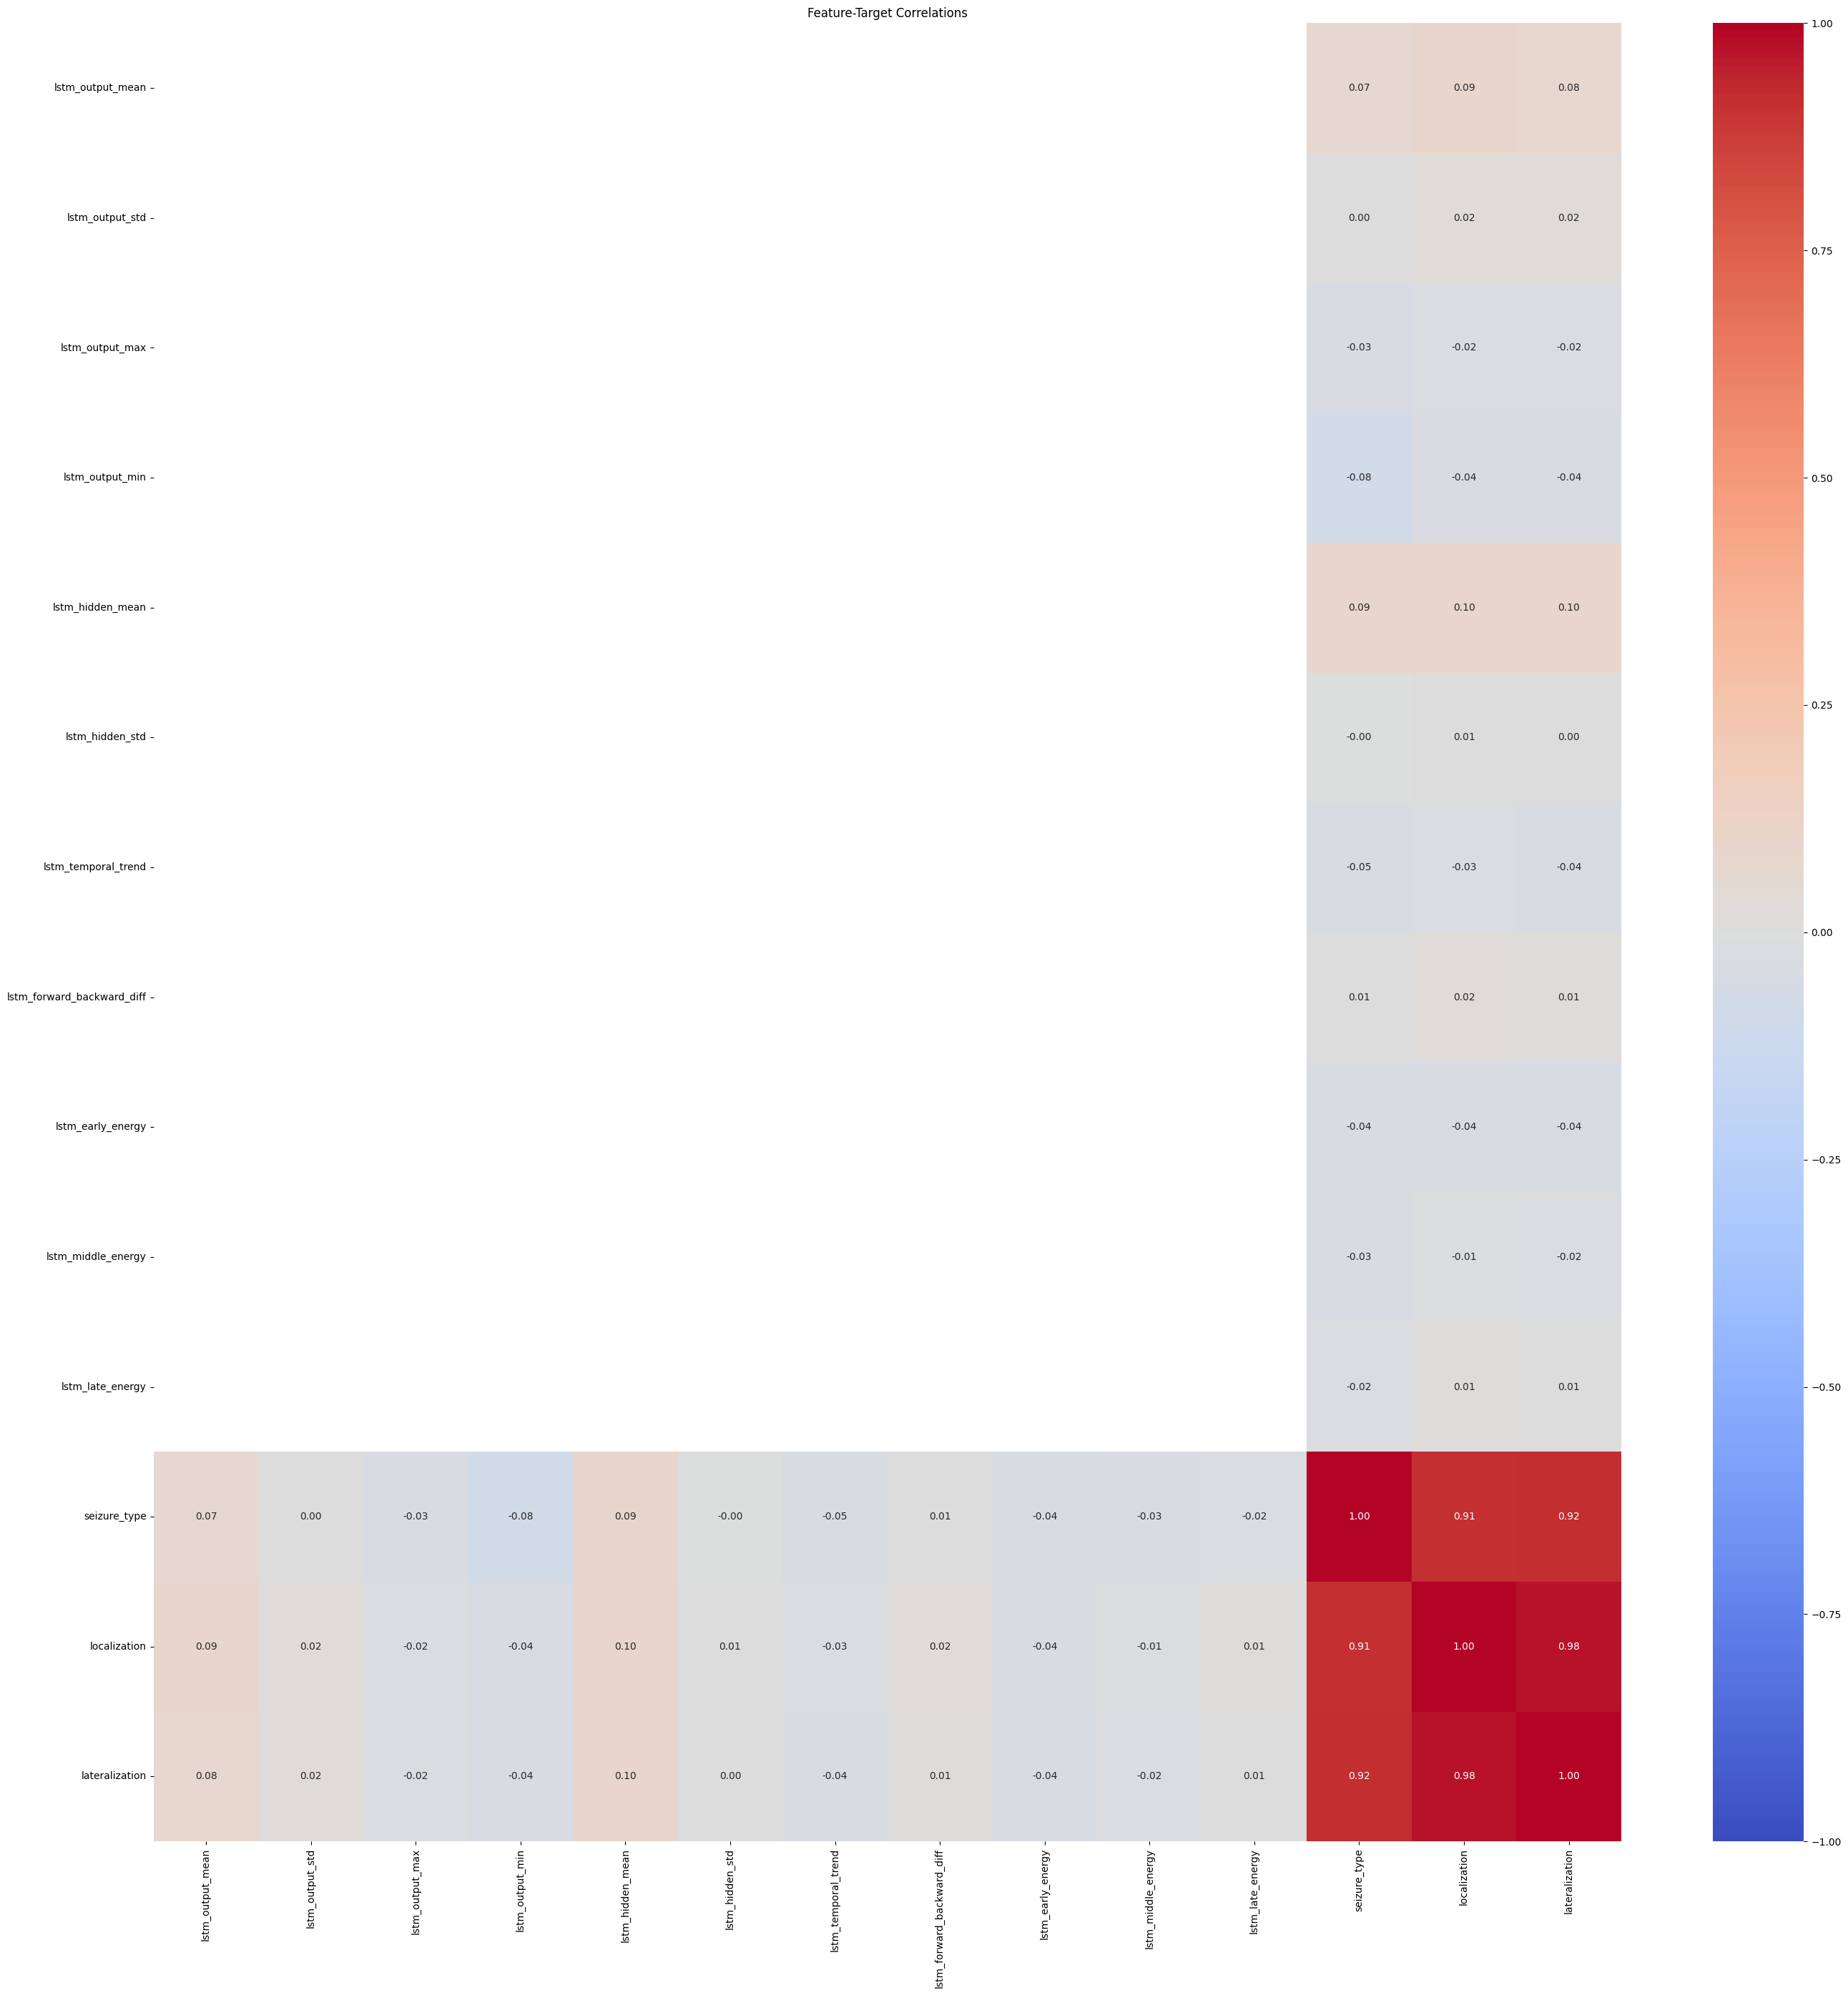


Correlations with targets (sorted):

seizure_type correlations:
  lateralization: 0.916
  localization: 0.914
  lstm_hidden_mean: 0.087
  lstm_output_min: -0.084
  lstm_output_mean: 0.069
  lstm_temporal_trend: -0.046
  lstm_early_energy: -0.044
  lstm_middle_energy: -0.034
  lstm_output_max: -0.031
  lstm_late_energy: -0.017
  lstm_forward_backward_diff: 0.005
  lstm_hidden_std: -0.003
  lstm_output_std: 0.003

localization correlations:
  lateralization: 0.976
  seizure_type: 0.914
  lstm_hidden_mean: 0.101
  lstm_output_mean: 0.090
  lstm_output_min: -0.038
  lstm_early_energy: -0.037
  lstm_temporal_trend: -0.031
  lstm_output_std: 0.023
  lstm_forward_backward_diff: 0.017
  lstm_output_max: -0.016
  lstm_middle_energy: -0.015
  lstm_late_energy: 0.009
  lstm_hidden_std: 0.006

lateralization correlations:
  localization: 0.976
  seizure_type: 0.916
  lstm_hidden_mean: 0.098
  lstm_output_mean: 0.083
  lstm_early_energy: -0.041
  lstm_temporal_trend: -0.041
  lstm_output_min: -0.0

In [91]:
features_to_keep, features_to_remove, key_features = plot_correlation_matrix(encoded_df, plot_output_path)